In [48]:
import sys
import time
import warnings
from tabulate import tabulate
import matplotlib.pyplot as plt

from typing import Any, ClassVar, Dict, List, Optional, Tuple, Type, TypeVar, Union

import gymnasium as gym
from gymnasium import spaces

import numpy as np
import pandas as pd
import torch as th
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from collections import Counter
from scipy.stats import skew, kurtosis
import seaborn as sns
import copy

from stable_baselines3.common.buffers import RolloutBuffer

from stable_baselines3.common.policies import ActorCriticCnnPolicy, ActorCriticPolicy, BasePolicy, MultiInputActorCriticPolicy
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.buffers import DictRolloutBuffer, RolloutBuffer
from stable_baselines3.common.callbacks import BaseCallback

from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import explained_variance, get_schedule_fn, obs_as_tensor, safe_mean
from stable_baselines3.common.vec_env import VecEnv

#### DATA

FUNCTIONS

In [49]:
def gbm_simulator_with_deltas(S0, mu, sigma, n_days=12, n_sequences=50000, annual_trading_days=252):
    sequences = []
    delta_sequences = []
    
    for i in range(n_sequences):
        # Time horizon and time step
        T = n_days / annual_trading_days
        dt = T / n_days
        
        # Time vector
        t = np.linspace(0, T, n_days)
        
        # Generate Wiener process increments
        W_increments = np.random.normal(0, np.sqrt(dt), n_days)
        W = np.cumsum(W_increments)  # Cumulative Wiener process
        
        # Geometric Brownian Motion (GBM) process
        S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
        
        # Calculate price deltas (differences between consecutive prices)
        Delta_GBM = np.diff(S)  # Price deltas
        
        sequences.append(S)
        delta_sequences.append(Delta_GBM)
    
    return np.array(sequences), np.array(delta_sequences)

def tokenize_deltas(data, bin_start, bin_stop, bin_width):
    # Assuming data is a NumPy array of shape (n_sequences, seq_length)
    n_sequences, seq_length = data.shape

    # Bin range and Bin width
    num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
    bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Tokenize each sequence individually (no flattening)
    tokenized_sequences = np.empty_like(data)

    for i in range(n_sequences):
        tokenized_data = np.digitize(data[i], bins=bin_edges, right=False) - 1
        tokenized_sequences[i] = np.clip(tokenized_data, 0, num_bins - 1)

    # Split the data based on 60/20/20 ratio
    train_size = int(0.6 * n_sequences)
    val_size = int(0.2 * n_sequences)
    
    train_data = tokenized_sequences[:train_size]  # First 60% of sequences for training
    val_data = tokenized_sequences[train_size:train_size + val_size]  # Next 20% for validation
    test_data = tokenized_sequences[train_size + val_size:]  # Remaining 20% for testing

    print('Number of Tokens:', num_bins)
    print('Training Data Shape:', train_data.shape)
    print('Validation Data Shape:', val_data.shape)
    print('Test Data Shape:', test_data.shape)

    return train_data, val_data, test_data, num_bins

def calculate_entropy(sequence, base='ln'):
    """
    Calculate Shannon entropy of a sequence.
    Entropy in specified units (bits/nats/bans)
    """
    # Count tokens
    token_counts = Counter(sequence)
    total_tokens = len(sequence)
    
    # Calculate probabilities
    probabilities = {token: count / total_tokens 
                    for token, count in token_counts.items()}
    
    # Choose log function
    if base == 'log2':
        log_fn = np.log2    # bits (common in information theory)
    elif base == 'ln':
        log_fn = np.log     # nats (natural units)
    else:
        log_fn = np.log10   # bans (base-10)
    
    # Calculate entropy with numerical stability
    eps = 1e-10  # Small constant to avoid log(0)
    entropy = -sum(p * log_fn(max(p, eps)) for p in probabilities.values())
    
    return entropy

def kl_divergence(real_sequence, fake_sequence, base='ln'):
    real_counts = Counter(real_sequence)
    fake_counts = Counter(fake_sequence)
    
    total_real = len(real_sequence)
    total_fake = len(fake_sequence)
    
    real_probs = {token: count/total_real for token, count in real_counts.items()}
    fake_probs = {token: count/total_fake for token, count in fake_counts.items()}
    
    # Choose log base
    if base == 'log2':
        log_fn = np.log2
    elif base == 'ln':
        log_fn = np.log
    else:  # log10
        log_fn = np.log10
    
    eps = 1e-10  # Small constant for numerical stability
    kl = 0
    for token, p_real in real_probs.items():
        p_fake = fake_probs.get(token, eps)
        if p_real > 0:  # Only compute for non-zero probabilities
            kl += p_real * log_fn(max(p_real, eps) / max(p_fake, eps))
    
    return kl

def calculate_statistics(trajectories):
    means = []
    variances = []
    std_devs = []
    skewness = []
    kurtos = []
    max_vals = []
    min_vals = []

    for traj in trajectories:
        means.append(np.mean(traj))
        variances.append(np.var(traj))
        std_devs.append(np.std(traj))
        skewness.append(skew(traj))
        kurtos.append(kurtosis(traj))
        max_vals.append(np.max(traj))
        min_vals.append(np.min(traj))
    
    return means, variances, std_devs, skewness, kurtos, max_vals, min_vals



SETTINGS

In [50]:
S0 = 100                # Initial stock price
mu = 0.1                # Annual drift
sigma = 0.2             # Volatility
n_days = 12             # Sequence length (52 days)
n_sequences = 50000     # Number of sequences to simulate

Price_GBM, Delta_GBM = gbm_simulator_with_deltas(S0, mu, sigma, n_days=n_days, n_sequences=n_sequences)

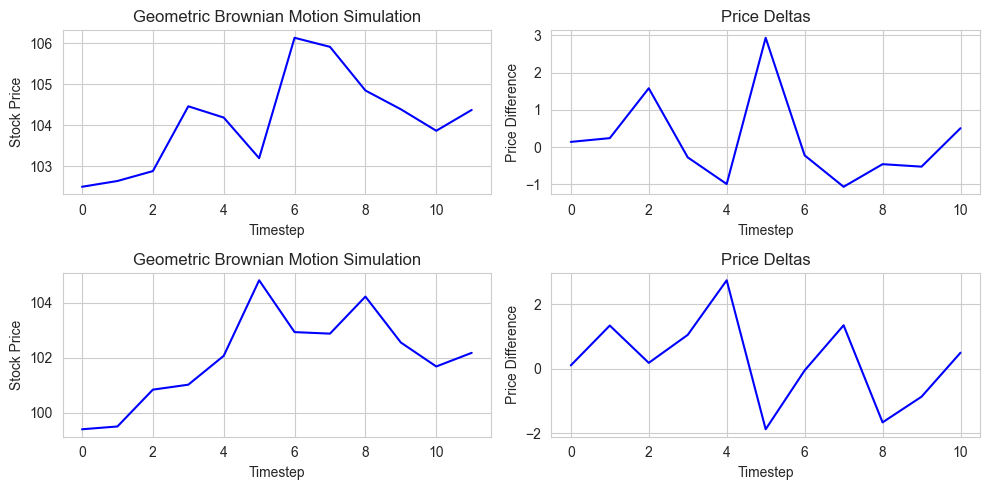

In [51]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs[0,0].plot(Price_GBM[0], color='blue')
axs[0,0].set_title('Geometric Brownian Motion Simulation')
axs[0,0].set_xlabel('Timestep')
axs[0,0].set_ylabel('Stock Price')
axs[0,0].grid('True')

axs[0,1].plot(Delta_GBM[0], color='blue')
axs[0,1].set_title('Price Deltas')
axs[0,1].set_xlabel('Timestep')
axs[0,1].set_ylabel('Price Difference')
axs[0,1].grid('True')

axs[1,0].plot(Price_GBM[5], color='blue')
axs[1,0].set_title('Geometric Brownian Motion Simulation')
axs[1,0].set_xlabel('Timestep')
axs[1,0].set_ylabel('Stock Price')
axs[1,0].grid('True')

axs[1,1].plot(Delta_GBM[5], color='blue')
axs[1,1].set_title('Price Deltas')
axs[1,1].set_xlabel('Timestep')
axs[1,1].set_ylabel('Price Difference')
axs[1,1].grid('True')
plt.tight_layout()
plt.show()

BIN WIDTH

In [52]:
bin_width = 0.3
print('Standard Deviation of Price Deltas:', np.round(np.std(Delta_GBM.flatten()),3))
print('BIN WIDTH: ', bin_width)

Standard Deviation of Price Deltas: 1.263
BIN WIDTH:  0.3


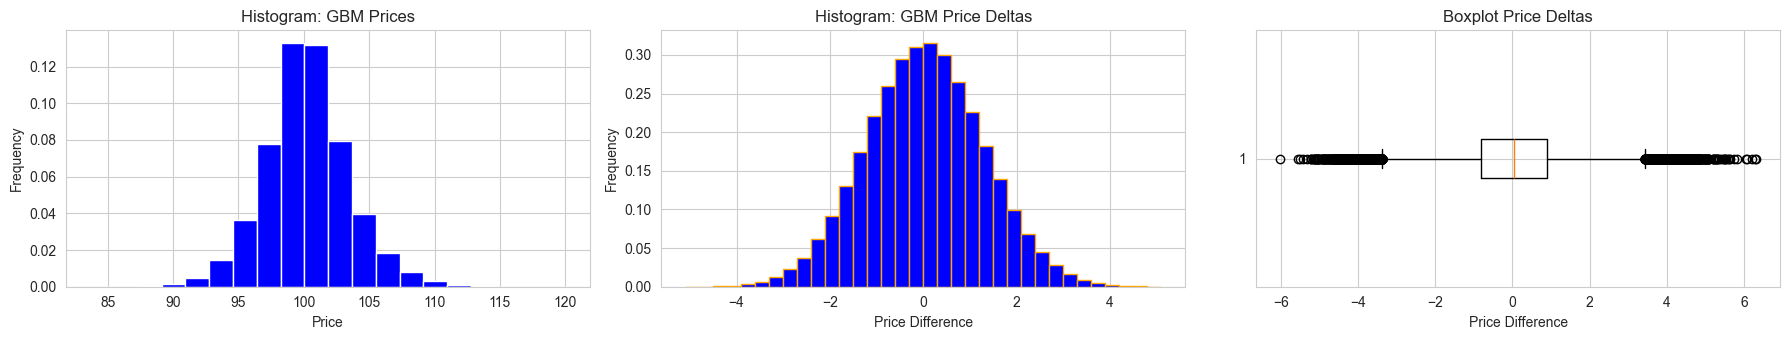

In [53]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

# Histogram: GBM Prices
axs[0].hist(Price_GBM.flatten(), bins=20, color='blue', density=True)
axs[0].set_title('Histogram: GBM Prices')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Frequency')

bins = np.arange(-5.1, 5.1 + bin_width, bin_width)

# Histogram: GBM Price Deltas
axs[1].hist(Delta_GBM.flatten(), 
            bins=bins, 
            edgecolor='orange', color='blue', density=True)
axs[1].set_title('Histogram: GBM Price Deltas')
axs[1].set_xlabel('Price Difference')
axs[1].set_ylabel('Frequency')

# Boxplot Price Deltas
axs[2].boxplot(Delta_GBM.flatten(), vert=False)
axs[2].set_title('Boxplot Price Deltas')
axs[2].set_xlabel('Price Difference')
plt.tight_layout()
plt.show()


TOKENIZE DATA

In [54]:
train_data, val_data, test_data, token_size = tokenize_deltas(Delta_GBM, bin_start=-5.1, bin_stop=5.1, bin_width=bin_width)

Number of Tokens: 34
Training Data Shape: (30000, 11)
Validation Data Shape: (10000, 11)
Test Data Shape: (10000, 11)


#### Train setting:

| Train set:                           |     30'000  Sequences        |
| ------------------------------------ | ---------------------------- |
| **Sequence Length:**                 | **50**                       |             
| **Batch size:**                      | **512**                      |


In [55]:
input_dim = token_size                          # Example vocab size (number of tokens)
hidden_dim = 64                                 # Hidden Dimension
output_dim = input_dim                          # Output Dimension
sequence_lengthseq_len = len(train_data[0])     # Length of your tokenized sequences

batch_size = 512                                # Batch Size
learning_rate = 0.001                           # Learning Rate
num_epochs = 10                                 # Number of epochs to train

MLP ARCHITECTURE

In [56]:
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPModel, self).__init__()
        # First hidden layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Second hidden layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Output layer
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Flatten: [batch_size * seq_len, input_dim]
        x = x.reshape(-1, 1)
        #x = x.view(x.size(0) * x.size(1), -1)
        # Fully connected layers with ACTIVATION FUNCTION
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        # Output layer: [batch_size * seq_len, output_dim]
        logits = self.fc_out(out)
        return logits

TRAINING

In [57]:
model_supervised = MLPModel(input_dim=1, hidden_dim=hidden_dim, output_dim=token_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_supervised.parameters(), lr=learning_rate)


# Convert data to float type
train_supervised = th.tensor(train_data, dtype=th.float)
val_supervised = th.tensor(val_data, dtype=th.float)

val_inputs = th.tensor(val_data[:, :-1], dtype=th.float)
val_targets = th.tensor(val_data[:, 1:], dtype=th.long)
val_targets = val_targets.reshape(-1)


train_losses = []
val_losses = []

best_val_loss = float('inf')

for epoch in range(num_epochs):

    temp_train_loss = []
    temp_val_loss = []
    
    ## ============
    ## TRAINING
    ## ============
    
    # Shuffle the data at the beginning of the epoch
    indices = th.randperm(len(train_supervised))
    
    for batch_idx in range(0, len(train_supervised), batch_size):
        
        model_supervised.train()
        
        batch_indices = indices[batch_idx:batch_idx + batch_size]
        batch = train_supervised[batch_indices]

        inputs = batch[:, :-1]
        targets = batch[:, 1:].long()

        logits = model_supervised(inputs)
        targets = targets.reshape(-1)           # Flatten targets: (batch_size * seq_len)

        loss = criterion(logits, targets)

        optimizer.zero_grad()                   # Reset gradients
        loss.backward()                         # Backpropagation
        optimizer.step()                        # Update the model parameters

        train_losses.append(loss.item())
        temp_train_loss.append(loss.item())

        ## ============
        ## VALIDATION
        ## ============

        model_supervised.eval()

        with th.no_grad():

            logits = model_supervised(val_inputs)
            loss = criterion(logits, val_targets)
            val_losses.append(loss.item())
            temp_val_loss.append(loss.item())
        
        if loss.item() < best_val_loss:
            best_val_loss = loss.item()
            th.save(model_supervised.state_dict(), 'supervised_weights.pth')

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {np.mean(temp_train_loss):.4f} - Val Loss: {np.mean(temp_val_loss):.4f}")


Epoch 1/10 - Train Loss: 3.0765 - Val Loss: 3.0408
Epoch 2/10 - Train Loss: 2.8749 - Val Loss: 2.8747
Epoch 3/10 - Train Loss: 2.8682 - Val Loss: 2.8682
Epoch 4/10 - Train Loss: 2.8630 - Val Loss: 2.8632
Epoch 5/10 - Train Loss: 2.8627 - Val Loss: 2.8625
Epoch 6/10 - Train Loss: 2.8614 - Val Loss: 2.8610
Epoch 7/10 - Train Loss: 2.8612 - Val Loss: 2.8612
Epoch 8/10 - Train Loss: 2.8606 - Val Loss: 2.8607
Epoch 9/10 - Train Loss: 2.8609 - Val Loss: 2.8608
Epoch 10/10 - Train Loss: 2.8607 - Val Loss: 2.8610


Entropy of Validation Data: 2.859


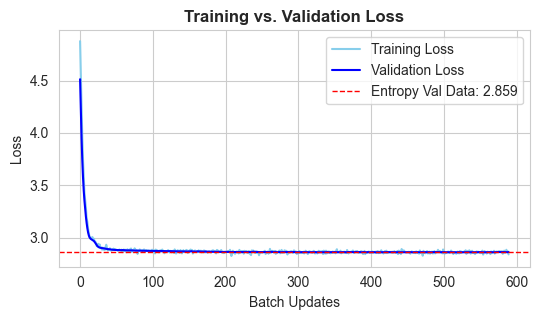

In [126]:
# Entropy calculation and display
entropy_val = round(calculate_entropy(np.concatenate(val_data), base='ln'),3)
print('Entropy of Validation Data:', entropy_val)

# Create the plot
plt.figure(figsize=(5.5, 3.3))
plt.plot(train_losses, label='Training Loss', color='skyblue', linewidth=1.5)
plt.plot(val_losses, label='Validation Loss', color='blue', linewidth=1.5)
plt.axhline(entropy_val, color='red', linestyle='--', linewidth=1, label=f'Entropy Val Data: {entropy_val}')
plt.title('Training vs. Validation Loss', fontweight='bold')
plt.xlabel('Batch Updates')
plt.ylabel('Loss')
plt.legend(loc='best', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()

#### Inference on Test Data

In [59]:
inference_model = MLPModel(input_dim=1, hidden_dim=hidden_dim, output_dim=token_size)
inference_model.load_state_dict(th.load('supervised_weights.pth', weights_only=False))

test_data_inference = th.tensor(test_data, dtype=th.float)

test_losses = []
trajectories = []

inference_model.eval()

with th.no_grad():
    
    for sequence in test_data_inference:

        token_loss = 0

        init_real_token = sequence[0]
        sim_trajectory = [init_real_token]
        
        for i in range(1, len(sequence)):

            input = sim_trajectory[-1].reshape(-1, 1, 1)

            logits = inference_model(input)
            
            probs = F.softmax(logits, dim=-1).squeeze()
            predicted_token = th.multinomial(probs, num_samples=1).squeeze()
            
            sim_trajectory.append(predicted_token.float())

            # Loss
            true_token = sequence[i].unsqueeze(-1)

            loss = criterion(logits.squeeze(1), true_token.long())
            token_loss += loss.item()

        test_losses.append(token_loss/len(sequence))
        trajectories.append(sim_trajectory)



KL Divergence

$D_{KL}(P_{\text{real}} \parallel P_{\text{fake}}) = \sum_{i} p_{\text{real}}(x_i) \log_2 \left( \frac{p_{\text{real}}(x_i)}{p_{\text{fake}}(x_i)} \right)$

In [60]:
kl_div = kl_divergence(real_sequence=np.concatenate(np.array(test_data_inference)),
              fake_sequence=np.concatenate(trajectories),
              base='log2')
print("KL Divergence between Real and Fake Sequences (in bits):", round(kl_div,5))

KL Divergence between Real and Fake Sequences (in bits): 0.00125


In [61]:
# Statistics for real and simulated trajectories
real_means, real_variances, real_std_devs, real_skew, real_kurtosis, real_max_vals, real_min_vals = calculate_statistics(test_data)
sim_means, sim_variances, sim_std_devs, sim_skew, sim_kurtosis, sim_max_vals, sim_min_vals = calculate_statistics(trajectories)

bin_start_mean = min(np.min(sim_means), np.min(real_means))
bin_stop_mean = max(np.max(sim_means), np.max(real_means))
bin_width_mean = 0.5
bin_edges_mean = np.arange(bin_start_mean, bin_stop_mean + bin_width_mean, bin_width_mean)

bin_start_var = min(np.min(sim_variances), np.min(real_variances))
bin_stop_var = max(np.max(sim_variances), np.max(real_variances))
bin_width_var = 2
bin_edges_var = np.arange(bin_start_var, bin_stop_var + bin_width_var, bin_width_var)

bin_start_skew = min(np.min(sim_skew), np.min(real_skew))
bin_stop_skew = max(np.max(sim_skew), np.max(real_skew))
bin_width_skew = 0.2
bin_edges_skew = np.arange(bin_start_skew, bin_stop_skew + bin_width_skew, bin_width_skew)

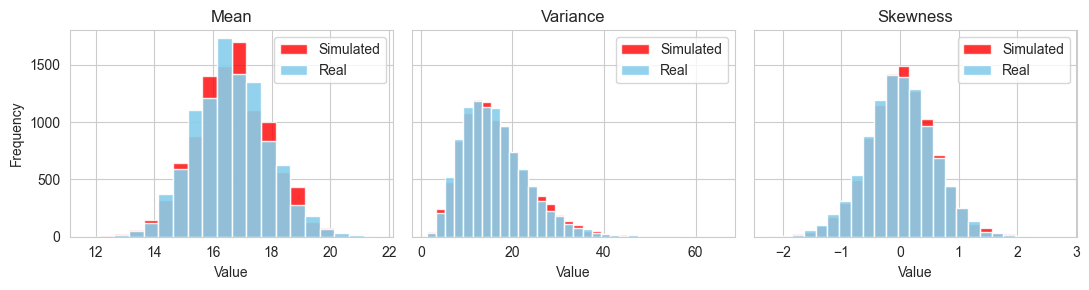

In [62]:
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})  # Adjust grid transparency to 0.3

fig, axs = plt.subplots(1, 3, figsize=(11, 3))

# Plot 1: Mean Distribution
axs[0].hist(sim_means, bins=bin_edges_mean, alpha=0.8, label='Simulated', color='red')
axs[0].hist(real_means, bins=bin_edges_mean, alpha=0.9, label='Real', color='skyblue')
axs[0].legend(loc='upper right')
axs[0].set_title('Mean')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')
axs[0].set_ylim(0,1800)

# Plot 1: Variance Distribution
axs[1].hist(sim_variances, bins=bin_edges_var, alpha=0.8, label='Simulated', color='red')
axs[1].hist(real_variances, bins=bin_edges_var, alpha=0.9, label='Real', color='skyblue')
axs[1].legend(loc='upper right')
axs[1].set_title('Variance')
axs[1].set_xlabel('Value')
axs[1].set_ylim(0,1800)
axs[1].tick_params(labelleft=False)

# Plot 2: Skewness Distribution
axs[2].hist(sim_skew, bins=bin_edges_skew, alpha=0.8, label='Simulated', color='red')
axs[2].hist(real_skew, bins=bin_edges_skew, alpha=0.9, label='Real', color='skyblue')
axs[2].legend(loc='upper right')
axs[2].set_title('Skewness')
axs[2].set_xlabel('Value')
axs[2].set_ylim(0,1800)
axs[2].tick_params(labelleft=False)
plt.subplots_adjust(wspace=0.05)  # Reduce space between plots
plt.tight_layout()
plt.show()

TRAJECTORY COMPARISON

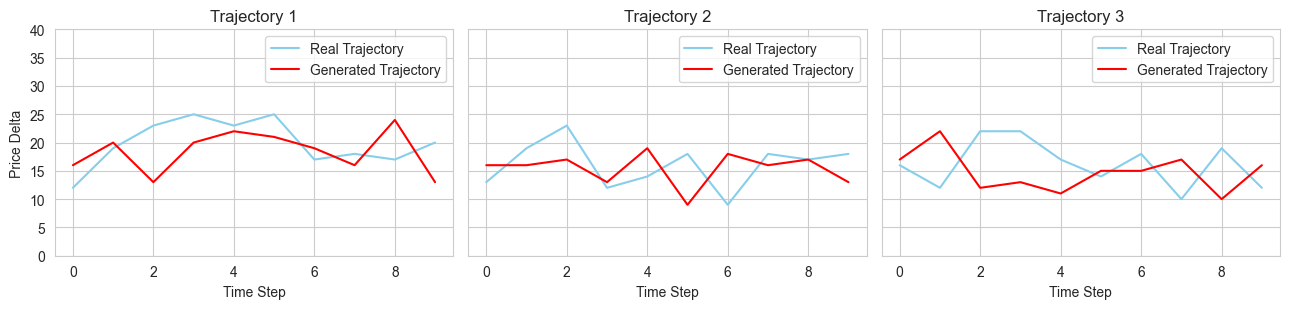

In [63]:
# Set Seaborn style with custom grid transparency
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})  # Adjust grid transparency to 0.3

# Create the subplots
fig, axes = plt.subplots(1, 3, figsize=(13, 3.2))  # 1 row, 3 columns
axes = axes.flatten()

# Plot the real and simulated trajectories
for i in range(3):
    axes[i].plot(test_data[i][1:], label='Real Trajectory', color='skyblue', linewidth=1.5)
    axes[i].plot(trajectories[i][1:], label='Generated Trajectory', color='red', linewidth=1.5)
    axes[i].legend(loc='best')
    axes[i].set_title(f'Trajectory {i+1}')
    axes[i].set_ylim(0, 40)
    axes[i].set_xlabel('Time Step')
    
    if i == 0:  # Only set y-axis label on the first plot
        axes[i].set_ylabel('Price Delta')
    else:
        axes[i].tick_params(labelleft=False)  # Remove y-axis labels and ticks for the 2nd and 3rd plots

# Adjust spacing between plots to bring them closer
plt.subplots_adjust(wspace=0)  # Reduce space between plots
plt.tight_layout()
plt.show()

### GAIL VANILLA MODEL

In [64]:
SelfOnPolicyAlgorithm = TypeVar("SelfOnPolicyAlgorithm", bound="OnPolicyAlgorithm")


class OnPolicyAlgorithm(BaseAlgorithm):
    """
    The base for On-Policy algorithms (ex: A2C/PPO).

    :param policy: The policy model to use (MlpPolicy, CnnPolicy, ...)
    :param env: The environment to learn from (if registered in Gym, can be str)
    :param learning_rate: The learning rate, it can be a function
        of the current progress remaining (from 1 to 0)
    :param n_steps: The number of steps to run for each environment per update
        (i.e. batch size is n_steps * n_env where n_env is number of environment copies running in parallel)
    :param gamma: Discount factor
    :param gae_lambda: Factor for trade-off of bias vs variance for Generalized Advantage Estimator.
        Equivalent to classic advantage when set to 1.
    :param ent_coef: Entropy coefficient for the loss calculation
    :param vf_coef: Value function coefficient for the loss calculation
    :param max_grad_norm: The maximum value for the gradient clipping
    :param use_sde: Whether to use generalized State Dependent Exploration (gSDE)
        instead of action noise exploration (default: False)
    :param sde_sample_freq: Sample a new noise matrix every n steps when using gSDE
        Default: -1 (only sample at the beginning of the rollout)
    :param rollout_buffer_class: Rollout buffer class to use. If ``None``, it will be automatically selected.
    :param rollout_buffer_kwargs: Keyword arguments to pass to the rollout buffer on creation.
    :param stats_window_size: Window size for the rollout logging, specifying the number of episodes to average
        the reported success rate, mean episode length, and mean reward over
    :param tensorboard_log: the log location for tensorboard (if None, no logging)
    :param monitor_wrapper: When creating an environment, whether to wrap it
        or not in a Monitor wrapper.
    :param policy_kwargs: additional arguments to be passed to the policy on creation
    :param verbose: Verbosity level: 0 for no output, 1 for info messages (such as device or wrappers used), 2 for
        debug messages
    :param seed: Seed for the pseudo random generators
    :param device: Device (cpu, cuda, ...) on which the code should be run.
        Setting it to auto, the code will be run on the GPU if possible.
    :param _init_setup_model: Whether or not to build the network at the creation of the instance
    :param supported_action_spaces: The action spaces supported by the algorithm.
    """

    rollout_buffer: RolloutBuffer
    policy: ActorCriticPolicy

    def __init__(
        self,
        policy: Union[str, Type[ActorCriticPolicy]],
        env: Union[GymEnv, str],
        learning_rate: Union[float, Schedule],
        n_steps: int,
        gamma: float,
        gae_lambda: float,
        ent_coef: float,
        vf_coef: float,
        max_grad_norm: float,
        use_sde: bool,
        sde_sample_freq: int,
        rollout_buffer_class: Optional[Type[RolloutBuffer]] = None,
        rollout_buffer_kwargs: Optional[Dict[str, Any]] = None,
        stats_window_size: int = 100,
        tensorboard_log: Optional[str] = None,
        monitor_wrapper: bool = True,
        policy_kwargs: Optional[Dict[str, Any]] = None,
        verbose: int = 0,
        seed: Optional[int] = None,
        device: Union[th.device, str] = "auto",
        _init_setup_model: bool = True,
        supported_action_spaces: Optional[Tuple[Type[spaces.Space], ...]] = None,
    ):
        super().__init__(
            policy=policy,
            env=env,
            learning_rate=learning_rate,
            policy_kwargs=policy_kwargs,
            verbose=verbose,
            device=device,
            use_sde=use_sde,
            sde_sample_freq=sde_sample_freq,
            support_multi_env=True,
            monitor_wrapper=monitor_wrapper,
            seed=seed,
            stats_window_size=stats_window_size,
            tensorboard_log=tensorboard_log,
            supported_action_spaces=supported_action_spaces,
        )

        self.n_steps = n_steps
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.ent_coef = ent_coef
        self.vf_coef = vf_coef
        self.max_grad_norm = max_grad_norm
        self.rollout_buffer_class = rollout_buffer_class
        self.rollout_buffer_kwargs = rollout_buffer_kwargs or {}

        if _init_setup_model:
            self._setup_model()

        ##============##
        # CUSTOM
        ##============##
        self.rollout_counter = 0
        ##============##
        # CUSTOM
        ##============##

    def _setup_model(self) -> None:
        self._setup_lr_schedule()
        self.set_random_seed(self.seed)

        if self.rollout_buffer_class is None:
            if isinstance(self.observation_space, spaces.Dict):
                self.rollout_buffer_class = DictRolloutBuffer
            else:
                self.rollout_buffer_class = RolloutBuffer

        self.rollout_buffer = self.rollout_buffer_class(
            self.n_steps,
            self.observation_space,  # type: ignore[arg-type]
            self.action_space,
            device=self.device,
            gamma=self.gamma,
            gae_lambda=self.gae_lambda,
            n_envs=self.n_envs,
            **self.rollout_buffer_kwargs,
        )
        self.policy = self.policy_class(  # type: ignore[assignment]
            self.observation_space, self.action_space, self.lr_schedule, use_sde=self.use_sde, **self.policy_kwargs
        )
        self.policy = self.policy.to(self.device)
        # Warn when not using CPU with MlpPolicy
        self._maybe_recommend_cpu()

    def _maybe_recommend_cpu(self, mlp_class_name: str = "ActorCriticPolicy") -> None:
        """
        Recommend to use CPU only when using A2C/PPO with MlpPolicy.

        :param: The name of the class for the default MlpPolicy.
        """
        policy_class_name = self.policy_class.__name__
        if self.device != th.device("cpu") and policy_class_name == mlp_class_name:
            warnings.warn(
                f"You are trying to run {self.__class__.__name__} on the GPU, "
                "but it is primarily intended to run on the CPU when not using a CNN policy "
                f"(you are using {policy_class_name} which should be a MlpPolicy). "
                "See https://github.com/DLR-RM/stable-baselines3/issues/1245 "
                "for more info. "
                "You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU."
                "Note: The model will train, but the GPU utilization will be poor and "
                "the training might take longer than on CPU.",
                UserWarning,
            )

    def collect_rollouts(
        self,
        env: VecEnv,
        callback: BaseCallback,
        rollout_buffer: RolloutBuffer,
        n_rollout_steps: int,
    ) -> bool:

        self.rollout_counter += 1

        """
        Collect experiences using the current policy and fill a ``RolloutBuffer``.
        The term rollout here refers to the model-free notion and should not
        be used with the concept of rollout used in model-based RL or planning.

        :param env: The training environment
        :param callback: Callback that will be called at each step
            (and at the beginning and end of the rollout)
        :param rollout_buffer: Buffer to fill with rollouts
        :param n_rollout_steps: Number of experiences to collect per environment
        :return: True if function returned with at least `n_rollout_steps`
            collected, False if callback terminated rollout prematurely.
        """
        assert self._last_obs is not None, "No previous observation was provided"
        # Switch to eval mode (this affects batch norm / dropout)
        self.policy.set_training_mode(False)

        n_steps = 0
        rollout_buffer.reset()
        # Sample new weights for the state dependent exploration
        if self.use_sde:
            self.policy.reset_noise(env.num_envs)

        callback.on_rollout_start()

        while n_steps < n_rollout_steps:
            if self.use_sde and self.sde_sample_freq > 0 and n_steps % self.sde_sample_freq == 0:
                # Sample a new noise matrix
                self.policy.reset_noise(env.num_envs)

            with th.no_grad():
                # Convert to pytorch tensor or to TensorDict
                obs_tensor = obs_as_tensor(self._last_obs, self.device)
                actions, values, log_probs = self.policy(obs_tensor)
            actions = actions.cpu().numpy()

            # Rescale and perform action
            clipped_actions = actions

            if isinstance(self.action_space, spaces.Box):
                if self.policy.squash_output:
                    # Unscale the actions to match env bounds
                    # if they were previously squashed (scaled in [-1, 1])
                    clipped_actions = self.policy.unscale_action(clipped_actions)
                else:
                    # Otherwise, clip the actions to avoid out of bound error
                    # as we are sampling from an unbounded Gaussian distribution
                    clipped_actions = np.clip(actions, self.action_space.low, self.action_space.high)

            new_obs, rewards, dones, infos = env.step(clipped_actions)

            self.num_timesteps += env.num_envs

            # Give access to local variables
            callback.update_locals(locals())
            if not callback.on_step():
                return False

            self._update_info_buffer(infos, dones)
            n_steps += 1

            if isinstance(self.action_space, spaces.Discrete):
                # Reshape in case of discrete action
                actions = actions.reshape(-1, 1)

            # Handle timeout by bootstrapping with value function
            # see GitHub issue #633
            for idx, done in enumerate(dones):
                if (
                    done
                    and infos[idx].get("terminal_observation") is not None
                    and infos[idx].get("TimeLimit.truncated", False)
                ):
                    terminal_obs = self.policy.obs_to_tensor(infos[idx]["terminal_observation"])[0]
                    with th.no_grad():
                        terminal_value = self.policy.predict_values(terminal_obs)[0]  # type: ignore[arg-type]
                    rewards[idx] += self.gamma * terminal_value

            rollout_buffer.add(
                self._last_obs,  # type: ignore[arg-type]
                actions,
                rewards,
                self._last_episode_starts,  # type: ignore[arg-type]
                values,
                log_probs,
            )
            self._last_obs = new_obs  # type: ignore[assignment]
            self._last_episode_starts = dones

        with th.no_grad():
            # Compute value for the last timestep
            values = self.policy.predict_values(obs_as_tensor(new_obs, self.device))  # type: ignore[arg-type]

        rollout_buffer.compute_returns_and_advantage(last_values=values, dones=dones)

        callback.update_locals(locals())

        callback.on_rollout_end()

        return True

    def train(self) -> None:
        """
        Consume current rollout data and update policy parameters.
        Implemented by individual algorithms.
        """
        raise NotImplementedError

    def _dump_logs(self, iteration: int) -> None:
        """
        Write log.

        :param iteration: Current logging iteration
        """
        assert self.ep_info_buffer is not None
        assert self.ep_success_buffer is not None

        time_elapsed = max((time.time_ns() - self.start_time) / 1e9, sys.float_info.epsilon)
        fps = int((self.num_timesteps - self._num_timesteps_at_start) / time_elapsed)
        self.logger.record("time/iterations", iteration, exclude="tensorboard")
        if len(self.ep_info_buffer) > 0 and len(self.ep_info_buffer[0]) > 0:
            self.logger.record("rollout/ep_rew_mean", safe_mean([ep_info["r"] for ep_info in self.ep_info_buffer]))
            self.logger.record("rollout/ep_len_mean", safe_mean([ep_info["l"] for ep_info in self.ep_info_buffer]))
        self.logger.record("time/fps", fps)
        self.logger.record("time/time_elapsed", int(time_elapsed), exclude="tensorboard")
        self.logger.record("time/total_timesteps", self.num_timesteps, exclude="tensorboard")
        if len(self.ep_success_buffer) > 0:
            self.logger.record("rollout/success_rate", safe_mean(self.ep_success_buffer))
        self.logger.dump(step=self.num_timesteps)

    def learn(
        self: SelfOnPolicyAlgorithm,
        total_timesteps: int,
        callback: MaybeCallback = None,
        log_interval: int = 1,
        tb_log_name: str = "OnPolicyAlgorithm",
        reset_num_timesteps: bool = True,
        progress_bar: bool = False,
    ) -> SelfOnPolicyAlgorithm:
        iteration = 0

        total_timesteps, callback = self._setup_learn(
            total_timesteps,
            callback,
            reset_num_timesteps,
            tb_log_name,
            progress_bar,
        )

        callback.on_training_start(locals(), globals())

        assert self.env is not None

        while self.num_timesteps < total_timesteps:
            continue_training = self.collect_rollouts(self.env, callback, self.rollout_buffer, n_rollout_steps=self.n_steps)

            if not continue_training:
                break

            iteration += 1
            self._update_current_progress_remaining(self.num_timesteps, total_timesteps)

            # Display training infos
            if log_interval is not None and iteration % log_interval == 0:
                assert self.ep_info_buffer is not None
                self._dump_logs(iteration)

            self.train()

        callback.on_training_end()

        return self

    def _get_torch_save_params(self) -> Tuple[List[str], List[str]]:
        state_dicts = ["policy", "policy.optimizer"]

        return state_dicts, []

In [65]:
SelfPPO = TypeVar("SelfPPO", bound="PPO")


class PPO(OnPolicyAlgorithm):
    """
    Proximal Policy Optimization algorithm (PPO) (clip version)

    Paper: https://arxiv.org/abs/1707.06347
    Code: This implementation borrows code from OpenAI Spinning Up (https://github.com/openai/spinningup/)
    https://github.com/ikostrikov/pytorch-a2c-ppo-acktr-gail and
    Stable Baselines (PPO2 from https://github.com/hill-a/stable-baselines)

    Introduction to PPO: https://spinningup.openai.com/en/latest/algorithms/ppo.html

    :param policy: The policy model to use (MlpPolicy, CnnPolicy, ...)
    :param env: The environment to learn from (if registered in Gym, can be str)
    :param learning_rate: The learning rate, it can be a function
        of the current progress remaining (from 1 to 0)
    :param n_steps: The number of steps to run for each environment per update
        (i.e. rollout buffer size is n_steps * n_envs where n_envs is number of environment copies running in parallel)
        NOTE: n_steps * n_envs must be greater than 1 (because of the advantage normalization)
        See https://github.com/pytorch/pytorch/issues/29372
    :param batch_size: Minibatch size
    :param n_epochs: Number of epoch when optimizing the surrogate loss
    :param gamma: Discount factor
    :param gae_lambda: Factor for trade-off of bias vs variance for Generalized Advantage Estimator
    :param clip_range: Clipping parameter, it can be a function of the current progress
        remaining (from 1 to 0).
    :param clip_range_vf: Clipping parameter for the value function,
        it can be a function of the current progress remaining (from 1 to 0).
        This is a parameter specific to the OpenAI implementation. If None is passed (default),
        no clipping will be done on the value function.
        IMPORTANT: this clipping depends on the reward scaling.
    :param normalize_advantage: Whether to normalize or not the advantage
    :param ent_coef: Entropy coefficient for the loss calculation
    :param vf_coef: Value function coefficient for the loss calculation
    :param max_grad_norm: The maximum value for the gradient clipping
    :param use_sde: Whether to use generalized State Dependent Exploration (gSDE)
        instead of action noise exploration (default: False)
    :param sde_sample_freq: Sample a new noise matrix every n steps when using gSDE
        Default: -1 (only sample at the beginning of the rollout)
    :param rollout_buffer_class: Rollout buffer class to use. If ``None``, it will be automatically selected.
    :param rollout_buffer_kwargs: Keyword arguments to pass to the rollout buffer on creation
    :param target_kl: Limit the KL divergence between updates,
        because the clipping is not enough to prevent large update
        see issue #213 (cf https://github.com/hill-a/stable-baselines/issues/213)
        By default, there is no limit on the kl div.
    :param stats_window_size: Window size for the rollout logging, specifying the number of episodes to average
        the reported success rate, mean episode length, and mean reward over
    :param tensorboard_log: the log location for tensorboard (if None, no logging)
    :param policy_kwargs: additional arguments to be passed to the policy on creation
    :param verbose: Verbosity level: 0 for no output, 1 for info messages (such as device or wrappers used), 2 for
        debug messages
    :param seed: Seed for the pseudo random generators
    :param device: Device (cpu, cuda, ...) on which the code should be run.
        Setting it to auto, the code will be run on the GPU if possible.
    :param _init_setup_model: Whether or not to build the network at the creation of the instance
    """

    policy_aliases: ClassVar[Dict[str, Type[BasePolicy]]] = {
        "MlpPolicy": ActorCriticPolicy,
        "CnnPolicy": ActorCriticCnnPolicy,
        "MultiInputPolicy": MultiInputActorCriticPolicy,
    }

    def __init__(
        self,
        policy: Union[str, Type[ActorCriticPolicy]],
        env: Union[GymEnv, str],
        learning_rate: Union[float, Schedule] = 3e-4,
        n_steps: int = 2048,
        batch_size: int = 64,
        n_epochs: int = 10,
        gamma: float = 0.99,
        gae_lambda: float = 0.95,
        clip_range: Union[float, Schedule] = 0.2,
        clip_range_vf: Union[None, float, Schedule] = None,
        normalize_advantage: bool = True,
        ent_coef: float = 0.0,
        vf_coef: float = 0.5,
        max_grad_norm: float = 0.5,
        use_sde: bool = False,
        sde_sample_freq: int = -1,
        rollout_buffer_class: Optional[Type[RolloutBuffer]] = None,
        rollout_buffer_kwargs: Optional[Dict[str, Any]] = None,
        target_kl: Optional[float] = None,
        stats_window_size: int = 100,
        tensorboard_log: Optional[str] = None,
        policy_kwargs: Optional[Dict[str, Any]] = None,
        verbose: int = 0,
        seed: Optional[int] = None,
        device: Union[th.device, str] = "auto",
        _init_setup_model: bool = True,
    ):
        super().__init__(
            policy,
            env,
            learning_rate=learning_rate,
            n_steps=n_steps,
            gamma=gamma,
            gae_lambda=gae_lambda,
            ent_coef=ent_coef,
            vf_coef=vf_coef,
            max_grad_norm=max_grad_norm,
            use_sde=use_sde,
            sde_sample_freq=sde_sample_freq,
            rollout_buffer_class=rollout_buffer_class,
            rollout_buffer_kwargs=rollout_buffer_kwargs,
            stats_window_size=stats_window_size,
            tensorboard_log=tensorboard_log,
            policy_kwargs=policy_kwargs,
            verbose=verbose,
            device=device,
            seed=seed,
            _init_setup_model=False,
            supported_action_spaces=(
                spaces.Box,
                spaces.Discrete,
                spaces.MultiDiscrete,
                spaces.MultiBinary,
            ),
        )

        # Sanity check, otherwise it will lead to noisy gradient and NaN
        # because of the advantage normalization
        if normalize_advantage:
            assert (
                batch_size > 1
            ), "`batch_size` must be greater than 1. See https://github.com/DLR-RM/stable-baselines3/issues/440"

        if self.env is not None:
            # Check that `n_steps * n_envs > 1` to avoid NaN
            # when doing advantage normalization
            buffer_size = self.env.num_envs * self.n_steps
            assert buffer_size > 1 or (
                not normalize_advantage
            ), f"`n_steps * n_envs` must be greater than 1. Currently n_steps={self.n_steps} and n_envs={self.env.num_envs}"
            # Check that the rollout buffer size is a multiple of the mini-batch size
            untruncated_batches = buffer_size // batch_size
            if buffer_size % batch_size > 0:
                warnings.warn(
                    f"You have specified a mini-batch size of {batch_size},"
                    f" but because the `RolloutBuffer` is of size `n_steps * n_envs = {buffer_size}`,"
                    f" after every {untruncated_batches} untruncated mini-batches,"
                    f" there will be a truncated mini-batch of size {buffer_size % batch_size}\n"
                    f"We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.\n"
                    f"Info: (n_steps={self.n_steps} and n_envs={self.env.num_envs})"
                )
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.clip_range = clip_range
        self.clip_range_vf = clip_range_vf
        self.normalize_advantage = normalize_advantage
        self.target_kl = target_kl

        if _init_setup_model:
            self._setup_model()
        
        ##============##
        # CUSTOM
        ##============##

        self.train_counter = 0
        self.update_model_loop = 0
        self.epoch_loops = 0

        self.avg_rollout_rew, self.avg_rollout_adv_mean, self.avg_rollout_adv_var = [], [], []
        self.total_losses, self.pg_losses, self.value_losses, self.entropy_losses = [], [], [], []
        self.policy_norm, self.approx_kl_div, self.clip_fraction, self.explained_var = [], [], [], []
        self.grad_norm_before, self.grad_norm_after = [], []

        ##============##
        # CUSTOM
        ##============##

    def _setup_model(self) -> None:
        super()._setup_model()

        # Initialize schedules for policy/value clipping
        self.clip_range = get_schedule_fn(self.clip_range)
        if self.clip_range_vf is not None:
            if isinstance(self.clip_range_vf, (float, int)):
                assert self.clip_range_vf > 0, "`clip_range_vf` must be positive, " "pass `None` to deactivate vf clipping"

            self.clip_range_vf = get_schedule_fn(self.clip_range_vf)

    def train(self) -> None:

        self.train_counter += 1

        #self.display_rollout_buffer(self.rollout_buffer)

        avg_rollout_rew, avg_rollout_adv_mean, avg_rollout_adv_var = self.calculate_metrices(self.rollout_buffer.rewards, self.rollout_buffer.episode_starts, self.rollout_buffer.advantages)
        self.avg_rollout_rew.append(avg_rollout_rew)
        self.avg_rollout_adv_mean.append(avg_rollout_adv_mean)
        self.avg_rollout_adv_var.append(avg_rollout_adv_var)

        
        """
        Update policy using the currently gathered rollout buffer.
        """
        
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update optimizer learning rate
        self._update_learning_rate(self.policy.optimizer)
        # Compute current clip range
        clip_range = self.clip_range(self._current_progress_remaining)  # type: ignore[operator]
        # Optional: clip range for the value function
        if self.clip_range_vf is not None:
            clip_range_vf = self.clip_range_vf(self._current_progress_remaining)  # type: ignore[operator]

        entropy_losses = []
        pg_losses, value_losses = [], []
        clip_fractions = []
        grad_norm_before, grad_norm_after = [], [] 
        
        ####
        total_losses = []
        ####
        
        continue_training = True
        # train for n_epochs epochs
        for epoch in range(self.n_epochs):

            self.epoch_loops += 1

            approx_kl_divs = []
            # Do a complete pass on the rollout buffer
            for rollout_data in self.rollout_buffer.get(self.batch_size):


                self.update_model_loop += 1


                actions = rollout_data.actions
                if isinstance(self.action_space, spaces.Discrete):
                    # Convert discrete action from float to long
                    actions = rollout_data.actions.long().flatten()

                values, log_prob, entropy = self.policy.evaluate_actions(rollout_data.observations, actions)
                values = values.flatten()
                # Normalize advantage
                advantages = rollout_data.advantages
                # Normalization does not make sense if mini batchsize == 1, see GH issue #325
                if self.normalize_advantage and len(advantages) > 1:
                    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

                # ratio between old and new policy, should be one at the first iteration
                ratio = th.exp(log_prob - rollout_data.old_log_prob)

                # clipped surrogate loss
                policy_loss_1 = advantages * ratio
                policy_loss_2 = advantages * th.clamp(ratio, 1 - clip_range, 1 + clip_range)
                policy_loss = -th.min(policy_loss_1, policy_loss_2).mean()

                # Logging
                pg_losses.append(policy_loss.item())
                clip_fraction = th.mean((th.abs(ratio - 1) > clip_range).float()).item()
                clip_fractions.append(clip_fraction)

                if self.clip_range_vf is None:
                    # No clipping
                    values_pred = values
                else:
                    # Clip the difference between old and new value
                    # NOTE: this depends on the reward scaling
                    values_pred = rollout_data.old_values + th.clamp(
                        values - rollout_data.old_values, -clip_range_vf, clip_range_vf
                    )
                # Value loss using the TD(gae_lambda) target
                value_loss = F.mse_loss(rollout_data.returns, values_pred)
                value_losses.append(value_loss.item())

                # Entropy loss favor exploration
                if entropy is None:
                    # Approximate entropy when no analytical form
                    entropy_loss = -th.mean(-log_prob)
                else:
                    entropy_loss = -th.mean(entropy)

                entropy_losses.append(entropy_loss.item())

                loss = policy_loss + self.ent_coef * entropy_loss + self.vf_coef * value_loss

                ####
                total_losses.append(loss.item())
                ####

                # Calculate approximate form of reverse KL Divergence for early stopping
                # see issue #417: https://github.com/DLR-RM/stable-baselines3/issues/417
                # and discussion in PR #419: https://github.com/DLR-RM/stable-baselines3/pull/419
                # and Schulman blog: http://joschu.net/blog/kl-approx.html
                with th.no_grad():
                    log_ratio = log_prob - rollout_data.old_log_prob
                    approx_kl_div = th.mean((th.exp(log_ratio) - 1) - log_ratio).cpu().numpy()
                    approx_kl_divs.append(approx_kl_div)

                if self.target_kl is not None and approx_kl_div > 1.5 * self.target_kl:
                    continue_training = False
                    if self.verbose >= 1:
                        print(f"Early stopping at step {epoch} due to reaching max kl: {approx_kl_div:.2f}")
                    break

                # Optimization step
                self.policy.optimizer.zero_grad()
                loss.backward()

                # Gradient Norm before clipping
                total_norm = 0.0
                for param in self.policy.parameters():
                    if param.grad is not None:
                        param_norm = param.grad.data.norm(2)
                        total_norm += param_norm.item() ** 2
                total_norm = total_norm ** 0.5
                grad_norm_before.append(total_norm)

                # Clip grad norm
                th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)

                # Gradient Norm after clipping
                total_norm_after = 0.0
                for param in self.policy.parameters():
                    if param.grad is not None:
                        param_norm = param.grad.data.norm(2)
                        total_norm_after += param_norm.item() ** 2
                total_norm_after = total_norm_after ** 0.5
                grad_norm_after.append(total_norm_after)
                            
                self.policy.optimizer.step()

            self._n_updates += 1
            if not continue_training:
                break

        explained_var = explained_variance(self.rollout_buffer.values.flatten(), self.rollout_buffer.returns.flatten())

        ######

        self.total_losses.extend(total_losses)
        self.pg_losses.extend(pg_losses)
        self.value_losses.extend(value_losses)
        self.entropy_losses.extend(entropy_losses)
        self.approx_kl_div.extend(approx_kl_divs)
        self.clip_fraction.extend(clip_fractions)
        self.grad_norm_before.extend(grad_norm_before)
        self.grad_norm_after.extend(grad_norm_after)
        self.explained_var.append(explained_var)

        ######

        # Logs
        self.logger.record("train/entropy_loss", np.mean(entropy_losses))
        self.logger.record("train/policy_gradient_loss", np.mean(pg_losses))
        self.logger.record("train/value_loss", np.mean(value_losses))
        self.logger.record("train/approx_kl", np.mean(approx_kl_divs))
        self.logger.record("train/clip_fraction", np.mean(clip_fractions))
        self.logger.record("train/loss", loss.item())
        self.logger.record("train/explained_variance", explained_var)
        if hasattr(self.policy, "log_std"):
            self.logger.record("train/std", th.exp(self.policy.log_std).mean().item())

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/clip_range", clip_range)
        if self.clip_range_vf is not None:
            self.logger.record("train/clip_range_vf", clip_range_vf)

    def learn(
        self: SelfPPO,
        total_timesteps: int,
        callback: MaybeCallback = None,
        log_interval: int = 1,
        tb_log_name: str = "PPO",
        reset_num_timesteps: bool = True,
        progress_bar: bool = False,
    ) -> SelfPPO:
        return super().learn(
            total_timesteps=total_timesteps,
            callback=callback,
            log_interval=log_interval,
            tb_log_name=tb_log_name,
            reset_num_timesteps=reset_num_timesteps,
            progress_bar=progress_bar,
        )
    
    def display_rollout_buffer(self, rollout_buffer):

        print("\nRollout Buffer Contents:")
        
        # Prepare data for tabulation
        data = []
        for i in range(rollout_buffer.buffer_size):

            if bool(rollout_buffer.episode_starts[i]) == True:
                    data.append({'observations': 'New Episode', 'actions': '', 'rewards': '',
                            'returns': '', 'episode_starts': '', 'values': '', 'log_probs': '', 'advantages': ''})
            row = {
                'observations': rollout_buffer.observations[i],
                'actions': rollout_buffer.actions[i],
                'rewards': rollout_buffer.rewards[i],
                'returns': rollout_buffer.returns[i],
                'episode_starts': rollout_buffer.episode_starts[i],
                'values': rollout_buffer.values[i],
                'log_probs': rollout_buffer.log_probs[i],
                'advantages': rollout_buffer.advantages[i]
            }
            data.append(row)
            # if not i == (rollout_buffer.buffer_size-1):
            #     if bool(rollout_buffer.episode_starts[i+1]) == True:
            #         data.append({'observations': 'New Episode', 'actions': '', 'rewards': '',
            #                 'returns': '', 'episode_starts': '', 'values': '', 'log_probs': '', 'advantages': ''})
        
        df = pd.DataFrame(data)
        pd.set_option('display.expand_frame_repr', False)  # Don't wrap to multiple lines
        pd.set_option('display.max_colwidth', None)  # Don't truncate column contents
        pd.set_option('display.width', None) 
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        print(df)
        print('')
        print('')
    
    def calculate_metrices(self, rewards, episode_starts, advantages):
        # Ensure inputs are numpy arrays
        rewards = np.array(rewards).flatten()
        episode_starts = np.array(episode_starts).flatten()
        advantages = np.array(advantages).flatten()
        
        # Find indices where episodes start
        episode_start_indices = np.where(episode_starts == 1)[0]

        if episode_starts[0] != 1:
            episode_start_indices = np.append(0, episode_start_indices)

        # Add the length of rewards as the last index to capture the last episode
        if episode_starts[len(episode_starts)-1] != 1:
            episode_start_indices = np.append(episode_start_indices, len(rewards))
        
        # Calculate rewards for each episode
        episode_rewards = []
        advantage_means = []
        advantage_vars = []
        for i in range(len(episode_start_indices) - 1):
            start = episode_start_indices[i]
            end = episode_start_indices[i+1]

            episode_reward = np.sum(rewards[start:end])
            advantage_mean = np.mean(advantages[start:end])
            advantage_var = np.var(advantages[start:end])

            episode_rewards.append(episode_reward)
            advantage_means.append(advantage_mean)
            advantage_vars.append(advantage_var)
        
        # Calculate average reward per episode
        average_reward = np.mean(episode_rewards)
        average_adv_mean = np.mean(advantage_means)
        average_adv_var = np.mean(advantage_vars)
        
        return average_reward, average_adv_mean, average_adv_var


#### PPO Parameters Explanation

##### Key Parameters

- **total_timesteps**: Total number of environment interactions
- **n_steps**: Number of environment interactions filled in the rollout buffer
- **batch_size**: Batch size used to update the model (out of n_steps/rollout_buffer, batch_size will be chosen to update)
- **n_epochs**: Number of updates with the same rollout buffer, so mini-batch size will be chosen n_epochs times and the model updated

##### Relationships and Calculations

- **Rollout Buffer Size** = n_steps
- **Rollout Buffers Loop** = total_timesteps / n_steps
- **Train Loop** = total_timesteps / n_steps
- **N_epoch Loop** = Train Loop * n_epochs
- **Number of Updates** = Train Loop * n_epochs * (n_steps / batch_size)

**Pendulum-v1**: Learning rate: **3e-4** Batch Size: **32**, total timesteps: **500'000**

**FrozenLake-v1**: Learning rate: **5e-4** Batch Size: **64**, total timesteps: **200'000**

**Taxi-v3** Learning rate: **5e-4** Batch Size: **64**, total timesteps: **75'000**

**LunarLander-v2** Learning rate: **7e-4** Batch Size: **64**, total timestep: **300'000**

### PPO Loss Components

#### 1. Policy Loss (Clipped Surrogate Objective)
$L^{CLIP}(\theta) = \hat{\mathbb{E}}_t[\min(r_t(\theta)\hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t)]$

where:
- $r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$ (probability ratio)
- $\epsilon$ is the clip range (e.g., 0.2)
- $\hat{A}_t$ is the advantage estimate

#### 2. Value Function Loss
$L^{VF}(\theta) = \frac{1}{N} \sum_{t=1}^{N} \left( V_\theta(s_t) - R_t \right)^2$

#### 3. Entropy Bonus
$L^{H}(\theta) = -\hat{\mathbb{E}}_t[\text{entropy}(\pi_\theta(\cdot|s_t))]$

#### Combined Loss
$L^{TOTAL}(\theta) = L^{CLIP}(\theta) - c_1 L^{VF}(\theta) + c_2 L^{H}(\theta)$

where:
- $c_1$ is vf_coef (default 0.5)
- $c_2$ is ent_coef (default 0.0)

#### GAN SUGGESTIONS:

Key principle: Keep discriminator slightly ahead but not too strong
- Start with k=5 discriminator updates per generator update
- Monitor discriminator accuracy:
  * If > 0.9: Too strong → reduce k or train generator more
  * If < 0.6: Too weak → increase k or train discriminator more
  * Ideal range: 0.7-0.8 accuracy

General rules:
- Discriminator LR < Generator LR (e.g., 1e-4 vs 3e-4)
- If discriminator too strong: reduce its LR
- If generator struggling: reduce its LR
- Use Adam optimizer with **beta1=0.5** (GAN standard)


Without buffer:
- Generator produces samples
- Discriminator trains on these latest samples
- Generator learns to exploit current discriminator weakness
- Can lead to instability

With buffer (e.g., size 10000) **(Did not implement that yet)**:
- Store generated samples in buffer
- When training discriminator:
  * 50% new generated samples
  * 50% random old samples from buffer
- Prevents oscillating behavior

In [66]:
class Discriminator(nn.Module):
    def __init__(self, sequence_length, hidden_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(sequence_length, hidden_size),            # First layer:              10 -> 256
            nn.ReLU(),                                      
            nn.Linear(hidden_size, hidden_size // 2),           # Second layer:             256 -> 128
            nn.ReLU(),                                      
            nn.Linear(hidden_size // 2, hidden_size // 4),      # Third layer:              128 -> 64
            nn.ReLU(),
            nn.Linear(hidden_size // 4, hidden_size // 8),      # Fourth layer:             64 -> 32
            nn.ReLU(),                                     
            nn.Linear(hidden_size // 8, 1)                      # Output layer (Logits)     32 -> 1
        )
    def forward(self, x):
        # x shape: [batch_size, sequence_length]
        return self.network(x)
        
def plot_training_results(model, env):
    
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(18,7.5))
    axs = axs.flatten()

    axs[0].plot(model.total_losses, color='blue')
    axs[0].set_title('Total Loss')
    axs[0].set_ylabel('Value')
    axs[0].set_xlabel('Batch Update')

    axs[1].plot(model.pg_losses, color='blue')
    axs[1].set_title('Policy Loss')
    axs[1].set_xlabel('Batch Update')
    axs[1].set_ylabel('Value')

    axs[2].plot(model.value_losses, color='blue')
    axs[2].set_title('Value Loss')
    axs[2].set_xlabel('Batch Update')
    axs[2].set_ylabel('Value')

    axs[3].plot(model.entropy_losses, color='blue')
    axs[3].set_title('Entropy Loss')
    axs[3].set_xlabel('Batch Update')
    axs[3].set_ylabel('Value')

    axs[4].plot(model.avg_rollout_rew, color='blue')
    axs[4].set_title('Avg Reward per Sequence')
    axs[4].set_xlabel('# of Rollout Buffer filled (total_timesteps/n_steps)')
    axs[4].set_ylabel('Reward')

    axs[5].plot(env.kl_divs, color='blue')
    axs[5].set_title('KL Div. real vs. sim sequences')
    axs[5].set_xlabel('# of Rollout Buffer filled')
    axs[5].set_ylabel('Value')

    axs[6].plot(env.d_losses, color='blue')
    axs[6].set_title('Discriminator Loss')
    axs[6].set_xlabel('# of Rollout Buffer filled')
    axs[6].set_ylabel('Value')

    axs[7].plot(env.d_accuracy, color='blue')
    axs[7].set_title('Discriminator Accuracy')
    axs[7].set_xlabel('# of Rollout Buffer filled')
    axs[7].set_ylabel('Value')

    plt.tight_layout()
    plt.show()

def plot_comparison(model1, model2, env1, env2):
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
    axs = axs.flatten()

    axs[0].plot(model1.avg_rollout_rew, color='red', label='w/out Entropy Loss')
    axs[0].plot(model2.avg_rollout_rew, color='blue', label='with Entropy Loss')
    axs[0].set_title('Avg Reward per Sequence')
    axs[0].set_xlabel('# of Rollout Buffer filled (total_timesteps/n_steps)')
    axs[0].set_ylabel('Reward')
    axs[0].legend()

    axs[1].plot(env1.kl_divs, color='red', label='w/out Entropy Loss')
    axs[1].plot(env2.kl_divs, color='blue', label='with Entropy Loss')
    axs[1].set_title('KL Div. real vs. sim sequences')
    axs[1].set_xlabel('# of Rollout Buffer filled')
    axs[1].set_ylabel('Value')
    axs[1].legend()

    axs[2].plot(env1.d_accuracy, color='red', label='w/out Entropy Loss')
    axs[2].plot(env2.d_accuracy, color='blue', label='wuth Entropy Loss')
    axs[2].set_title('Discriminator Accuracy')
    axs[2].set_xlabel('# of Rollout Buffer filled')
    axs[2].set_ylabel('Value')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

In [67]:
class CustomEnv(gym.Env):
    
    def __init__(self, data, token_size):

        super(CustomEnv, self).__init__()

        # Spaces
        self.action_space = spaces.Discrete(token_size)        # Action Space
        self.observation_space = spaces.Discrete(token_size)   # Observation Space

        # Data
        self.data = data
        self.seq_len = len(self.data[0])

        # Reset
        self.curr_seq = None
        self.curr_seq_sim = []
        self.seq_idx = 0
        
        self.real_data = []
        self.sim_data = []

        # Discriminator
        self.discriminator = Discriminator(sequence_length=10, hidden_size=256)
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=3e-4, betas=(0.5, 0.999))
        self.criterion = nn.BCEWithLogitsLoss()
        
        self.d_losses = []
        self.d_accuracy = []
        self.d_prob_real = []
        self.d_prob_fake = []
        self.kl_divs = []
    
    def step(self, action):

        assert self.action_space.contains(action), "Invalid Action"
        
        self.seq_idx += 1

        self.curr_seq_sim.append(action)

        done = self._is_done()

        if done:
            
            ###=====REWARD=====###
            loss = self.get_reward()
            reward = -(loss.item())
            ###=====REWARD=====###
            
            self.sim_data.append(self.curr_seq_sim)
            self.curr_seq_sim = []
        
        else:
            reward = 0

        next_obs = action

        return next_obs, reward, done, False, {}        # observation, reward, done, truncated, info

    def reset(self, *, seed = None, options = None):

        seq_idx = np.random.choice(len(self.data), size = 1).item()
        real_sequence = self.data[seq_idx]
        
        # Reset
        self.curr_seq = real_sequence
        self.seq_idx = 0
        self.real_data.append(real_sequence[1:])

        start_token = int(self.curr_seq[0])

        return start_token, {}      # observation, info

    def _is_done(self):

        if self.seq_idx == (self.seq_len - 1):
            return True
        else:
            return False

    def kl_divergence(self, base='ln'):
        
        real_counts = Counter(np.concatenate(self.real_data))
        fake_counts = Counter(np.concatenate(self.sim_data))
        
        total_real = len(np.concatenate(self.real_data))
        total_fake = len(np.concatenate(self.sim_data))
        
        real_probs = {token: count/total_real for token, count in real_counts.items()}
        fake_probs = {token: count/total_fake for token, count in fake_counts.items()}
        
        # Choose log base
        if base == 'log2':
            log_fn = np.log2
        elif base == 'ln':
            log_fn = np.log
        else:  # log10
            log_fn = np.log10
        
        eps = 1e-10  # Small constant for numerical stability
        kl = 0
        for token, p_real in real_probs.items():
            p_fake = fake_probs.get(token, eps)
            if p_real > 0:  # Only compute for non-zero probabilities
                kl += p_real * log_fn(max(p_real, eps) / max(p_fake, eps))
        
        self.kl_divs.append(kl)

        return kl
    
    def train_discriminator(self, epochs):
        
        self.discriminator.train()
        
        temp_d_loss = []
        temp_d_accuracy = []
        temp_prob_real = []
        temp_prob_fake = []

        for epoch in range(epochs):
            
            real_data = np.array(self.real_data)
            sim_data = np.array(self.sim_data)
            indices = th.randperm(len(sim_data))

            batch_real = th.tensor(real_data[indices], dtype=th.float32)
            batch_fake = th.tensor(sim_data[indices], dtype=th.float32)

            # Real data
            real_preds = self.discriminator(batch_real)
            real_labels = th.ones_like(real_preds)
            real_loss = self.criterion(real_preds, real_labels)

            # Fake data
            fake_preds = self.discriminator(batch_fake)
            fake_labels = th.zeros_like(fake_preds)
            fake_loss = self.criterion(fake_preds, fake_labels)

            d_loss = (real_loss + fake_loss) / 2

            self.d_optimizer.zero_grad()
            d_loss.backward()
            self.d_optimizer.step()

            with th.no_grad():
                 # Convert logits to probabilities using sigmoid
                real_probs = th.sigmoid(real_preds)
                fake_probs = th.sigmoid(fake_preds)
                # Count correct predictions
                correct_real = (real_probs >= 0.52).float().sum()
                correct_fake = (fake_probs < 0.48).float().sum()
                # Total samples
                total_samples = len(real_probs) + len(fake_probs)
                # Overall accuracy
                accuracy = (correct_real + correct_fake) / total_samples
                # For monitoring
                avg_prob_real = real_probs.mean()
                avg_prob_fake = fake_probs.mean()
            
            # Store metrics
            temp_d_loss.append(d_loss.item())
            temp_d_accuracy.append(accuracy.item())
            temp_prob_real.append(avg_prob_real.item())
            temp_prob_fake.append(avg_prob_fake.item())
        
        self.d_losses.append(np.mean(temp_d_loss))
        self.d_accuracy.append(np.mean(temp_d_accuracy))
        self.d_prob_real.append(np.mean(temp_prob_real))
        self.d_prob_fake.append(np.mean(temp_prob_fake))

        # Reset
        self.real_data = []
        self.sim_data = []

    def get_reward(self):
        
        self.discriminator.eval()
        
        with th.no_grad():
            temp_sequence = th.tensor(np.array(self.curr_seq_sim), dtype=th.float32)
            prediction = self.discriminator(temp_sequence)
            label = th.ones_like(prediction)
            seq_loss = self.criterion(prediction, label)
            return seq_loss


In [68]:
class SavePolicyCallback(BaseCallback):
    
    def __init__(self, env, verbose=0):
        super(SavePolicyCallback, self).__init__(verbose)
        self.env = env
    
    def _on_training_start(self) -> None:       # Before the first rollout starts.
        pass

    def _on_rollout_start(self) -> None:        # Before the rollouts start (2nd to last)
        pass
    
    def _on_step(self) -> bool:                 # Called after every `env.step()`.

        """
        This method will be called by the model after each call to `env.step()`.

        For child callback (of an `EventCallback`), this will be called
        when the event is triggered.

        :return: (bool) If the callback returns False, training is aborted early.
        """
        return True

    def _on_rollout_end(self) -> None:          # Called at the end of the rollout

        self.env.kl_divergence(base="log2")
        self.env.train_discriminator(epochs=40)

        print(f"KL Divergence: {self.env.kl_divs[-1]} - Discriminator Accuracy: {self.env.d_accuracy[-1]}")


In [69]:
env_1 = CustomEnv(data=train_data, token_size=token_size)

model_1 = PPO(

    policy="MlpPolicy",
    env=env_1,
    verbose=0,
    
    n_steps=400*10,
    batch_size = 400,
    n_epochs=3,
    
    
    gamma=1.0,              # 0.99
    gae_lambda=0.95,        # 0.95
    clip_range=0.2,
    clip_range_vf=None,
    ent_coef = 0.0,         # 0
    vf_coef = 0.5,
    max_grad_norm=0.5,

    learning_rate=1e-4,
    policy_kwargs=dict(
        optimizer_class=th.optim.Adam,
        optimizer_kwargs=dict(betas=(0.5, 0.999))   # Set beta1 = 0.5 like in GAN
        )
    )

callback_1 = SavePolicyCallback(env_1)

KL Divergence: 0.9993434001158897 - Discriminator Accuracy: 0.8471250042319298
KL Divergence: 0.9521258006400425 - Discriminator Accuracy: 0.9543437480926513
KL Divergence: 0.928444953576837 - Discriminator Accuracy: 0.9630937457084656
KL Divergence: 0.9370971585845405 - Discriminator Accuracy: 0.9692812502384186
KL Divergence: 0.944038686233393 - Discriminator Accuracy: 0.9658437520265579
KL Divergence: 0.9590538873709881 - Discriminator Accuracy: 0.9747812494635582
KL Divergence: 1.0439380140063141 - Discriminator Accuracy: 0.968343748152256
KL Divergence: 0.9912442172530475 - Discriminator Accuracy: 0.9716562524437904
KL Divergence: 0.9897527939375007 - Discriminator Accuracy: 0.970250004529953
KL Divergence: 0.9570432134315272 - Discriminator Accuracy: 0.9637187406420707
KL Divergence: 1.0027213961492063 - Discriminator Accuracy: 0.9690000072121621
KL Divergence: 0.9883379030349755 - Discriminator Accuracy: 0.9725937515497207
KL Divergence: 0.9669772064818465 - Discriminator Accura

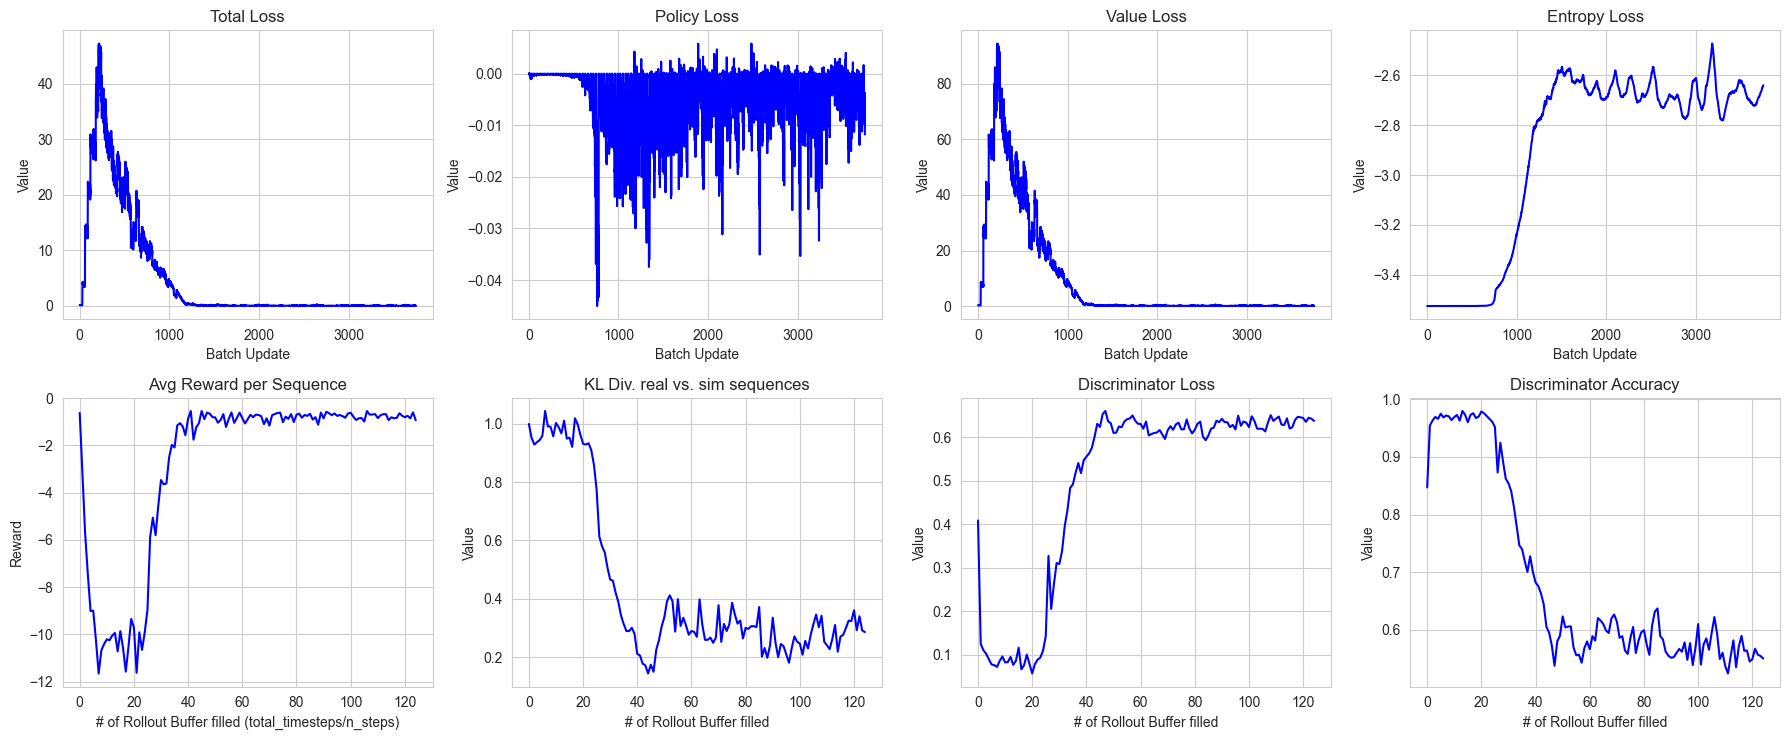

In [70]:
model_1.learn(500000, callback=callback_1)
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})
plot_training_results(model_1, env_1)
env_1.close()

In [79]:
sim_sequences = []

for sequence in val_data:
    
    _, _ = env_1.reset()
    done = False
    curr_seq_sim  = []

    action = sequence[0]

    while not done:
        action, _ = model_1.predict(action, deterministic=False)
        _, _, done, _, _ = env_1.step(action)
        curr_seq_sim.append(action.item())
    sim_sequences.append(curr_seq_sim)

real_seq = val_data[:,1:]
sim_seq = np.array(sim_sequences)

# Statistics for real and simulated trajectories
real_means, real_variances, real_std_devs, real_skew, real_kurtosis, real_max_vals, real_min_vals = calculate_statistics(real_seq)
sim_means, sim_variances, sim_std_devs, sim_skew, sim_kurtosis, sim_max_vals, sim_min_vals = calculate_statistics(sim_seq)

bin_start_mean = min(np.min(sim_means), np.min(real_means))
bin_stop_mean = max(np.max(sim_means), np.max(real_means))
bin_width_mean = 0.5
bin_edges_mean = np.arange(bin_start_mean, bin_stop_mean + bin_width_mean, bin_width_mean)

bin_start_var = min(np.min(sim_variances), np.min(real_variances))
bin_stop_var = max(np.max(sim_variances), np.max(real_variances))
bin_width_var = 2
bin_edges_var = np.arange(bin_start_var, bin_stop_var + bin_width_var, bin_width_var)

bin_start_skew = min(np.min(sim_skew), np.min(real_skew))
bin_stop_skew = max(np.max(sim_skew), np.max(real_skew))
bin_width_skew = 0.2
bin_edges_skew = np.arange(bin_start_skew, bin_stop_skew + bin_width_skew, bin_width_skew)

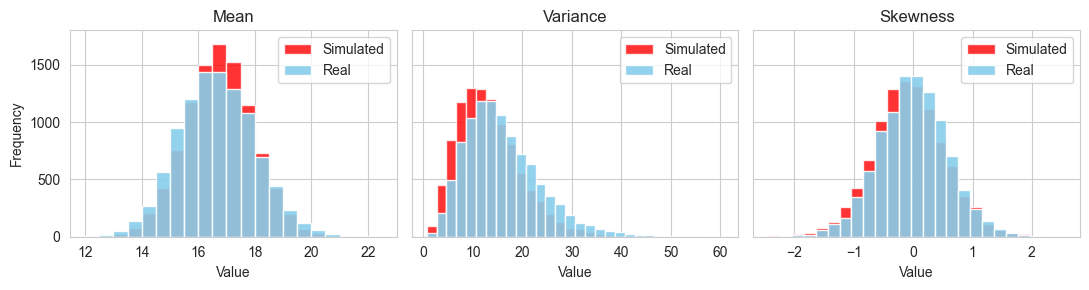

In [80]:
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})  # Adjust grid transparency to 0.3

fig, axs = plt.subplots(1, 3, figsize=(11, 3))

# Plot 1: Mean Distribution
axs[0].hist(sim_means, bins=bin_edges_mean, alpha=0.8, label='Simulated', color='red')
axs[0].hist(real_means, bins=bin_edges_mean, alpha=0.9, label='Real', color='skyblue')
axs[0].legend(loc='upper right')
axs[0].set_title('Mean')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')
axs[0].set_ylim(0,1800)

# Plot 1: Variance Distribution
axs[1].hist(sim_variances, bins=bin_edges_var, alpha=0.8, label='Simulated', color='red')
axs[1].hist(real_variances, bins=bin_edges_var, alpha=0.9, label='Real', color='skyblue')
axs[1].legend(loc='upper right')
axs[1].set_title('Variance')
axs[1].set_xlabel('Value')
axs[1].set_ylim(0,1800)
axs[1].tick_params(labelleft=False)

# Plot 2: Skewness Distribution
axs[2].hist(sim_skew, bins=bin_edges_skew, alpha=0.8, label='Simulated', color='red')
axs[2].hist(real_skew, bins=bin_edges_skew, alpha=0.9, label='Real', color='skyblue')
axs[2].legend(loc='upper right')
axs[2].set_title('Skewness')
axs[2].set_xlabel('Value')
axs[2].set_ylim(0,1800)
axs[2].tick_params(labelleft=False)
plt.subplots_adjust(wspace=0.05)  # Reduce space between plots
plt.tight_layout()
plt.show()

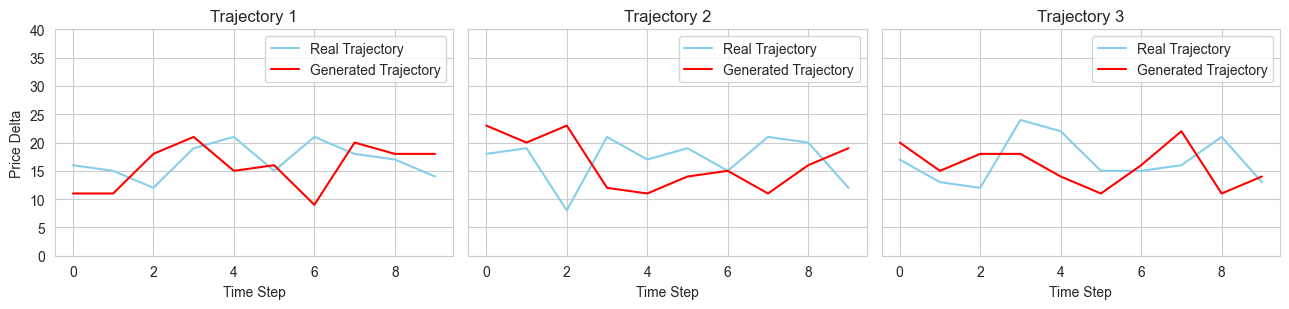

In [81]:
# Set Seaborn style with custom grid transparency
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})  # Adjust grid transparency to 0.3

# Create the subplots
fig, axes = plt.subplots(1, 3, figsize=(13, 3.2))  # 1 row, 3 columns
axes = axes.flatten()

# Plot the real and simulated trajectories
for i in range(3):
    axes[i].plot(real_seq[i+50], label='Real Trajectory', color='skyblue', linewidth=1.5)
    axes[i].plot(sim_seq[i+50], label='Generated Trajectory', color='red', linewidth=1.5)
    axes[i].legend(loc='best')
    axes[i].set_title(f'Trajectory {i+1}')
    axes[i].set_ylim(0, 40)
    axes[i].set_xlabel('Time Step')
    
    if i == 0:  # Only set y-axis label on the first plot
        axes[i].set_ylabel('Price Delta')
    else:
        axes[i].tick_params(labelleft=False)  # Remove y-axis labels and ticks for the 2nd and 3rd plots

# Adjust spacing between plots to bring them closer
plt.subplots_adjust(wspace=0)  # Reduce space between plots
plt.tight_layout()
plt.show()

In [83]:
kl_div_model1 = round(kl_divergence(np.concatenate(real_seq), np.concatenate(sim_seq), base='log2'),5)
print("KL Divergence between Real and Fake Sequences (in bits):", kl_div_model1)

KL Divergence between Real and Fake Sequences (in bits): 0.22614


In [84]:
entropy_model1 = round(calculate_entropy(np.concatenate(sim_seq), base='ln'),3)
print('Entropy of Validation Data:', entropy_model1)

Entropy of Validation Data: 2.636


### Gail with Entropy Loss included

In [85]:
env_2 = CustomEnv(data=train_data, token_size=token_size)

model_2 = PPO(

    policy="MlpPolicy",
    env=env_2,
    verbose=0,
    
    n_steps=400*10,
    batch_size = 400,
    n_epochs=3,
    
    gamma=1.0,              # 0.99
    gae_lambda=0.95,        # 0.95
    clip_range=0.2,
    clip_range_vf=None,
    ent_coef = 0.1,         # 0
    vf_coef = 0.5,
    max_grad_norm=0.5,

    learning_rate=1e-4,
    policy_kwargs=dict(
        optimizer_class=th.optim.Adam,
        optimizer_kwargs=dict(betas=(0.5, 0.999))   # Set beta1 = 0.5 like in GAN
        )
    )

callback_2 = SavePolicyCallback(env_2)

KL Divergence: 1.0209205781857553 - Discriminator Accuracy: 0.8620937503874302
KL Divergence: 0.9809610091946128 - Discriminator Accuracy: 0.9622499883174896
KL Divergence: 0.9718309478007489 - Discriminator Accuracy: 0.969093756377697
KL Divergence: 1.0047413429047714 - Discriminator Accuracy: 0.974687497317791
KL Divergence: 0.9753500838972141 - Discriminator Accuracy: 0.9763125061988831
KL Divergence: 0.9377637753429213 - Discriminator Accuracy: 0.970625002682209
KL Divergence: 0.9815719142366776 - Discriminator Accuracy: 0.9695312514901161
KL Divergence: 1.0051901591103722 - Discriminator Accuracy: 0.9777187451720237
KL Divergence: 1.044440671348915 - Discriminator Accuracy: 0.9789062544703484
KL Divergence: 1.0116262757298946 - Discriminator Accuracy: 0.9736250072717667
KL Divergence: 0.922455292785055 - Discriminator Accuracy: 0.9643124938011169
KL Divergence: 0.927399213932874 - Discriminator Accuracy: 0.9593124970793724
KL Divergence: 0.9610751500584246 - Discriminator Accuracy

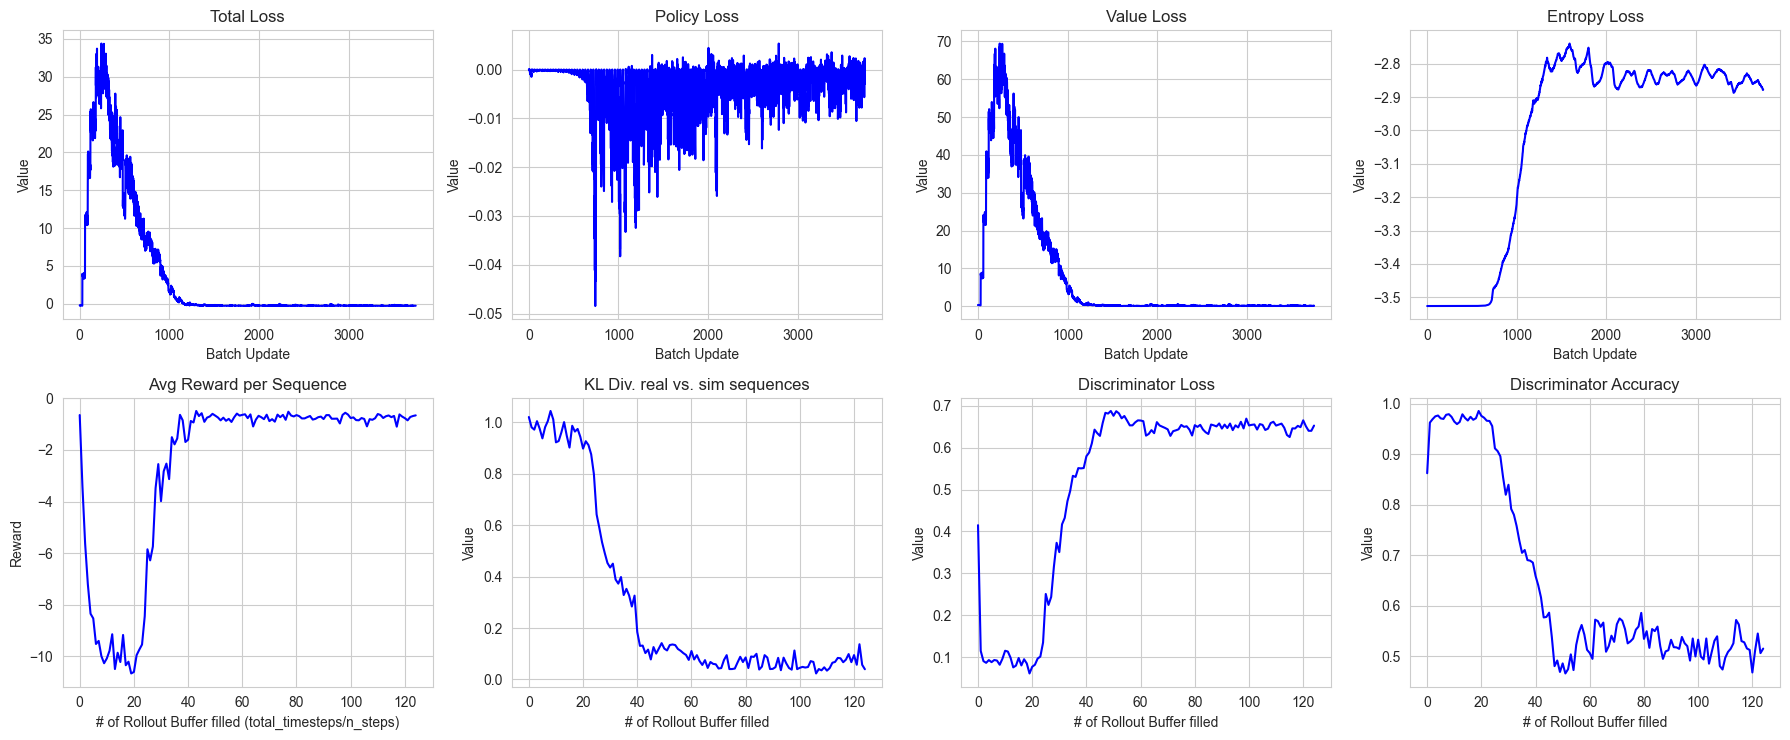

In [86]:
model_2.learn(500000, callback=callback_2)
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})
plot_training_results(model_2, env_2)
env_2.close()

In [87]:
sim_sequences = []

for sequence in val_data:
    
    _, _ = env_2.reset()
    done = False
    curr_seq_sim  = []

    action = sequence[0]

    while not done:
        action, _ = model_2.predict(action, deterministic=False)
        _, _, done, _, _ = env_2.step(action)
        curr_seq_sim.append(action.item())
    sim_sequences.append(curr_seq_sim)

real_seq = val_data[:,1:]
sim_seq = np.array(sim_sequences)

# Statistics for real and simulated trajectories
real_means, real_variances, real_std_devs, real_skew, real_kurtosis, real_max_vals, real_min_vals = calculate_statistics(real_seq)
sim_means, sim_variances, sim_std_devs, sim_skew, sim_kurtosis, sim_max_vals, sim_min_vals = calculate_statistics(sim_seq)

bin_start_mean = min(np.min(sim_means), np.min(real_means))
bin_stop_mean = max(np.max(sim_means), np.max(real_means))
bin_width_mean = 0.5
bin_edges_mean = np.arange(bin_start_mean, bin_stop_mean + bin_width_mean, bin_width_mean)

bin_start_var = min(np.min(sim_variances), np.min(real_variances))
bin_stop_var = max(np.max(sim_variances), np.max(real_variances))
bin_width_var = 2
bin_edges_var = np.arange(bin_start_var, bin_stop_var + bin_width_var, bin_width_var)

bin_start_skew = min(np.min(sim_skew), np.min(real_skew))
bin_stop_skew = max(np.max(sim_skew), np.max(real_skew))
bin_width_skew = 0.2
bin_edges_skew = np.arange(bin_start_skew, bin_stop_skew + bin_width_skew, bin_width_skew)

In [ ]:
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})  # Adjust grid transparency to 0.3

fig, axs = plt.subplots(1, 3, figsize=(11, 2.5))

# Plot 1: Mean Distribution
axs[0].hist(sim_means, bins=bin_edges_mean, alpha=0.8, label='Simulated', color='red')
axs[0].hist(real_means, bins=bin_edges_mean, alpha=0.9, label='Real', color='skyblue')
axs[0].legend(loc='upper right')
axs[0].set_title('Mean')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')
axs[0].set_ylim(0,1800)

# Plot 1: Variance Distribution
axs[1].hist(sim_variances, bins=bin_edges_var, alpha=0.8, label='Simulated', color='red')
axs[1].hist(real_variances, bins=bin_edges_var, alpha=0.9, label='Real', color='skyblue')
axs[1].legend(loc='upper right')
axs[1].set_title('Variance')
axs[1].set_xlabel('Value')
axs[1].set_ylim(0,1800)
axs[1].tick_params(labelleft=False)

# Plot 2: Skewness Distribution
axs[2].hist(sim_skew, bins=bin_edges_skew, alpha=0.8, label='Simulated', color='red')
axs[2].hist(real_skew, bins=bin_edges_skew, alpha=0.9, label='Real', color='skyblue')
axs[2].legend(loc='upper right')
axs[2].set_title('Skewness')
axs[2].set_xlabel('Value')
axs[2].set_ylim(0,1800)
axs[2].tick_params(labelleft=False)
plt.subplots_adjust(wspace=0.05)  # Reduce space between plots
plt.tight_layout()
plt.show()

In [ ]:
# Set Seaborn style with custom grid transparency
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})  # Adjust grid transparency to 0.3

# Create the subplots
fig, axes = plt.subplots(1, 3, figsize=(13, 3.2))  # 1 row, 3 columns
axes = axes.flatten()

# Plot the real and simulated trajectories
for i in range(3):
    axes[i].plot(real_seq[i+50], label='Real Trajectory', color='skyblue', linewidth=1.5)
    axes[i].plot(sim_seq[i+50], label='Generated Trajectory', color='red', linewidth=1.5)
    axes[i].legend(loc='best')
    axes[i].set_title(f'Trajectory {i+1}')
    axes[i].set_ylim(0, 40)
    axes[i].set_xlabel('Time Step')
    
    if i == 0:  # Only set y-axis label on the first plot
        axes[i].set_ylabel('Price Delta')
    else:
        axes[i].tick_params(labelleft=False)  # Remove y-axis labels and ticks for the 2nd and 3rd plots

# Adjust spacing between plots to bring them closer
plt.subplots_adjust(wspace=0)  # Reduce space between plots
plt.tight_layout()
plt.show()

In [90]:
kl_div_model2 = round(kl_divergence(np.concatenate(real_seq), np.concatenate(sim_seq), base='log2'),5)
print("KL Divergence between Real and Fake Sequences (in bits):", kl_div_model2)

KL Divergence between Real and Fake Sequences (in bits): 0.02681


In [91]:
entropy_model2 = round(calculate_entropy(np.concatenate(sim_seq), base='ln'),3)
print('Entropy of Validation Data:', entropy_model2)

Entropy of Validation Data: 2.872


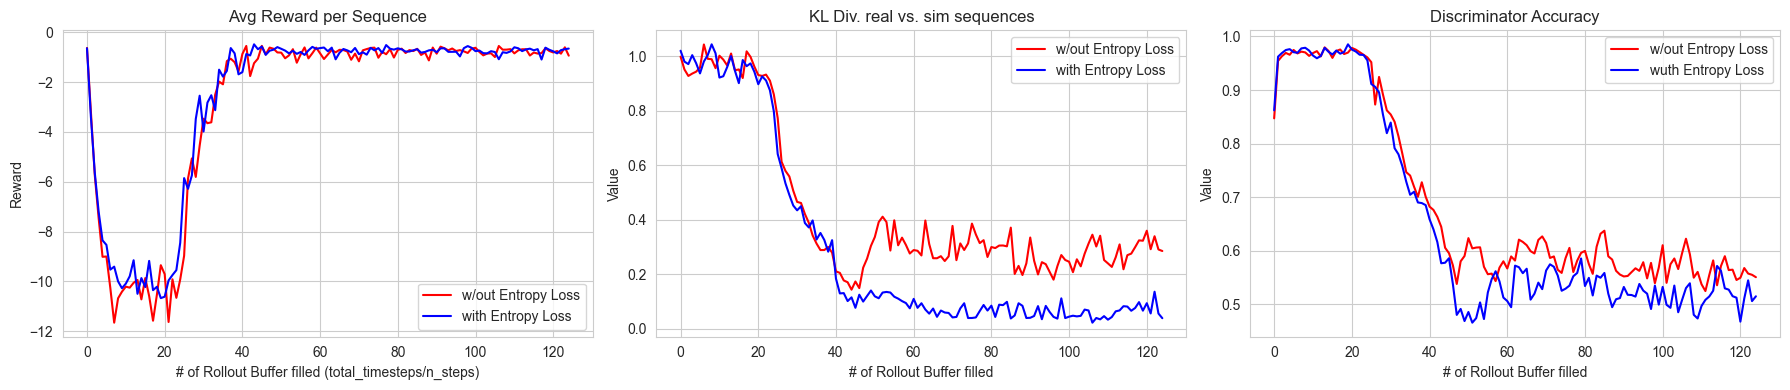

In [105]:
plot_comparison(model_1, model_2, env_1, env_2)

In [121]:
env_init = CustomEnv(data=train_data, token_size=token_size)

model_inint = PPO(

    policy="MlpPolicy",
    env=env_init,
    verbose=0,
    
    n_steps=400*10,
    batch_size = 400,
    n_epochs=3,
    
    gamma=1.0,              # 0.99
    gae_lambda=0.95,        # 0.95
    clip_range=0.2,
    clip_range_vf=None,
    ent_coef = 0.1,         # 0
    vf_coef = 0.5,
    max_grad_norm=0.5,

    learning_rate=1e-4,
    policy_kwargs=dict(
        optimizer_class=th.optim.Adam,
        optimizer_kwargs=dict(betas=(0.5, 0.999))   # Set beta1 = 0.5 like in GAN
        )
    )

callback_init = SavePolicyCallback(env_init)

In [123]:
sim_sequences = []

for sequence in val_data:
    
    _, _ = env_init.reset()
    done = False
    curr_seq_sim  = []

    action = sequence[0]

    while not done:
        action, _ = model_inint.predict(action, deterministic=False)
        _, _, done, _, _ = env_init.step(action)
        curr_seq_sim.append(action.item())
    sim_sequences.append(curr_seq_sim)

real_seq = val_data[:,1:]
sim_seq = np.array(sim_sequences)

In [124]:
entropy_init = round(calculate_entropy(np.concatenate(sim_seq), base='ln'),3)
print('Entropy of Validation Data:', entropy_init)

Entropy of Validation Data: 3.526


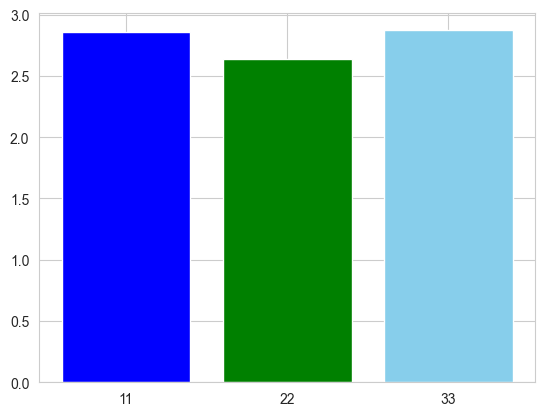

In [108]:
plt.bar(['11', '22', '33'], [entropy_val, entropy_model1, entropy_model2], color=('blue', 'green', 'skyblue'))
plt.show()


Random Initialization


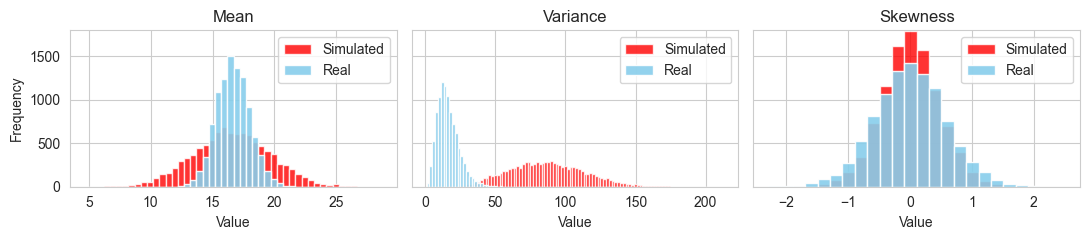

GAIL WITHOUT ENTROPY LOSS


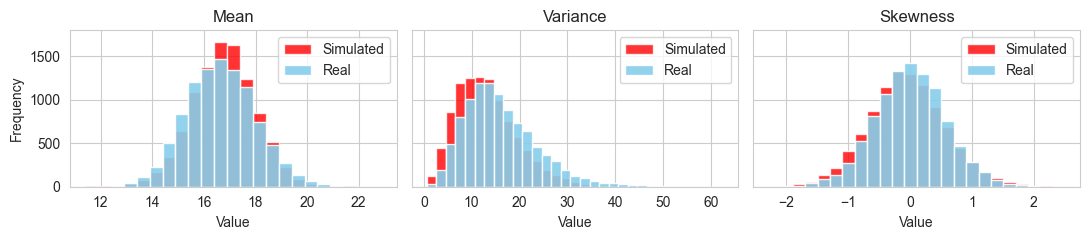

GAIL WITH ENTROPY LOSS


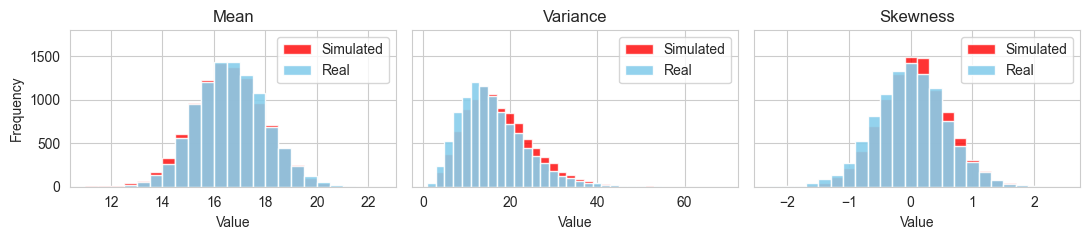

SUPERVISED TRAINING


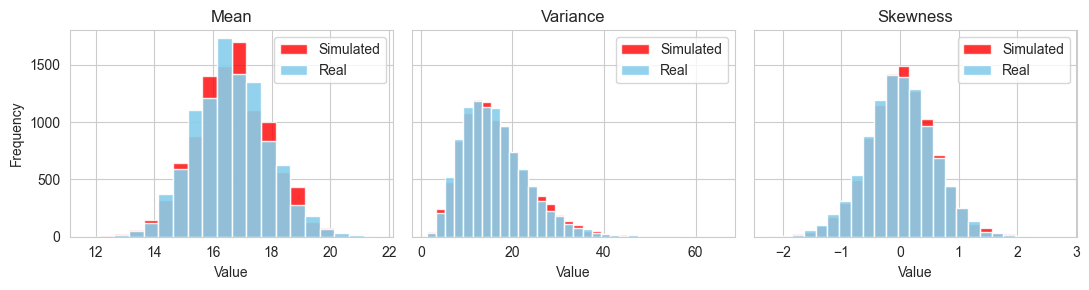

In [114]:
models = [[env_init, model_inint, 'Random Initialization'], [env_1, model_1, 'GAIL WITHOUT ENTROPY LOSS'], [env_2, model_2, 'GAIL WITH ENTROPY LOSS']]

for model in models:
        
    sim_sequences = []

    for sequence in val_data:
        
        _, _ = model[0].reset()
        done = False
        curr_seq_sim  = []

        action = sequence[0]

        while not done:
            action, _ = model[1].predict(action, deterministic=False)
            _, _, done, _, _ = model[0].step(action)
            curr_seq_sim.append(action.item())
        sim_sequences.append(curr_seq_sim)

    real_seq = val_data[:,1:]
    sim_seq = np.array(sim_sequences)

    # Statistics for real and simulated trajectories
    real_means, real_variances, real_std_devs, real_skew, real_kurtosis, real_max_vals, real_min_vals = calculate_statistics(real_seq)
    sim_means, sim_variances, sim_std_devs, sim_skew, sim_kurtosis, sim_max_vals, sim_min_vals = calculate_statistics(sim_seq)

    bin_start_mean = min(np.min(sim_means), np.min(real_means))
    bin_stop_mean = max(np.max(sim_means), np.max(real_means))
    bin_width_mean = 0.5
    bin_edges_mean = np.arange(bin_start_mean, bin_stop_mean + bin_width_mean, bin_width_mean)

    bin_start_var = min(np.min(sim_variances), np.min(real_variances))
    bin_stop_var = max(np.max(sim_variances), np.max(real_variances))
    bin_width_var = 2
    bin_edges_var = np.arange(bin_start_var, bin_stop_var + bin_width_var, bin_width_var)

    bin_start_skew = min(np.min(sim_skew), np.min(real_skew))
    bin_stop_skew = max(np.max(sim_skew), np.max(real_skew))
    bin_width_skew = 0.2
    bin_edges_skew = np.arange(bin_start_skew, bin_stop_skew + bin_width_skew, bin_width_skew)

    print(model[2])

    sns.set_style("whitegrid", rc={"grid.alpha": 0.5})  # Adjust grid transparency to 0.3

    fig, axs = plt.subplots(1, 3, figsize=(11, 2.5))

    # Plot 1: Mean Distribution
    axs[0].hist(sim_means, bins=bin_edges_mean, alpha=0.8, label='Simulated', color='red')
    axs[0].hist(real_means, bins=bin_edges_mean, alpha=0.9, label='Real', color='skyblue')
    axs[0].legend(loc='upper right')
    axs[0].set_title('Mean')
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Frequency')
    axs[0].set_ylim(0,1800)

    # Plot 1: Variance Distribution
    axs[1].hist(sim_variances, bins=bin_edges_var, alpha=0.8, label='Simulated', color='red')
    axs[1].hist(real_variances, bins=bin_edges_var, alpha=0.9, label='Real', color='skyblue')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Variance')
    axs[1].set_xlabel('Value')
    axs[1].set_ylim(0,1800)
    axs[1].tick_params(labelleft=False)

    # Plot 2: Skewness Distribution
    axs[2].hist(sim_skew, bins=bin_edges_skew, alpha=0.8, label='Simulated', color='red')
    axs[2].hist(real_skew, bins=bin_edges_skew, alpha=0.9, label='Real', color='skyblue')
    axs[2].legend(loc='upper right')
    axs[2].set_title('Skewness')
    axs[2].set_xlabel('Value')
    axs[2].set_ylim(0,1800)
    axs[2].tick_params(labelleft=False)
    plt.subplots_adjust(wspace=0.05)  # Reduce space between plots
    plt.tight_layout()
    plt.show()

# Statistics for real and simulated trajectories
real_means, real_variances, real_std_devs, real_skew, real_kurtosis, real_max_vals, real_min_vals = calculate_statistics(test_data)
sim_means, sim_variances, sim_std_devs, sim_skew, sim_kurtosis, sim_max_vals, sim_min_vals = calculate_statistics(trajectories)

bin_start_mean = min(np.min(sim_means), np.min(real_means))
bin_stop_mean = max(np.max(sim_means), np.max(real_means))
bin_width_mean = 0.5
bin_edges_mean = np.arange(bin_start_mean, bin_stop_mean + bin_width_mean, bin_width_mean)

bin_start_var = min(np.min(sim_variances), np.min(real_variances))
bin_stop_var = max(np.max(sim_variances), np.max(real_variances))
bin_width_var = 2
bin_edges_var = np.arange(bin_start_var, bin_stop_var + bin_width_var, bin_width_var)

bin_start_skew = min(np.min(sim_skew), np.min(real_skew))
bin_stop_skew = max(np.max(sim_skew), np.max(real_skew))
bin_width_skew = 0.2
bin_edges_skew = np.arange(bin_start_skew, bin_stop_skew + bin_width_skew, bin_width_skew)

print('SUPERVISED TRAINING')

sns.set_style("whitegrid", rc={"grid.alpha": 0.5})  # Adjust grid transparency to 0.3

fig, axs = plt.subplots(1, 3, figsize=(11, 3))

# Plot 1: Mean Distribution
axs[0].hist(sim_means, bins=bin_edges_mean, alpha=0.8, label='Simulated', color='red')
axs[0].hist(real_means, bins=bin_edges_mean, alpha=0.9, label='Real', color='skyblue')
axs[0].legend(loc='upper right')
axs[0].set_title('Mean')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')
axs[0].set_ylim(0,1800)

# Plot 1: Variance Distribution
axs[1].hist(sim_variances, bins=bin_edges_var, alpha=0.8, label='Simulated', color='red')
axs[1].hist(real_variances, bins=bin_edges_var, alpha=0.9, label='Real', color='skyblue')
axs[1].legend(loc='upper right')
axs[1].set_title('Variance')
axs[1].set_xlabel('Value')
axs[1].set_ylim(0,1800)
axs[1].tick_params(labelleft=False)

# Plot 2: Skewness Distribution
axs[2].hist(sim_skew, bins=bin_edges_skew, alpha=0.8, label='Simulated', color='red')
axs[2].hist(real_skew, bins=bin_edges_skew, alpha=0.9, label='Real', color='skyblue')
axs[2].legend(loc='upper right')
axs[2].set_title('Skewness')
axs[2].set_xlabel('Value')
axs[2].set_ylim(0,1800)
axs[2].tick_params(labelleft=False)
plt.subplots_adjust(wspace=0.05)  # Reduce space between plots
plt.tight_layout()
plt.show()

Random Initialization


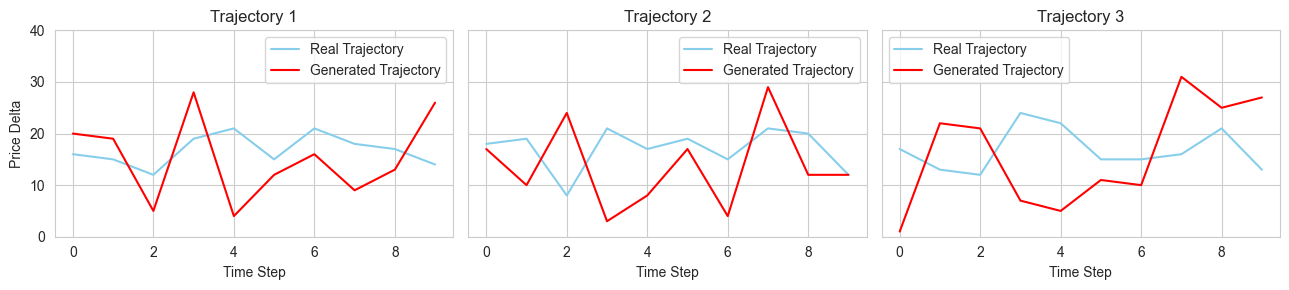

GAIL WITHOUT ENTROPY LOSS


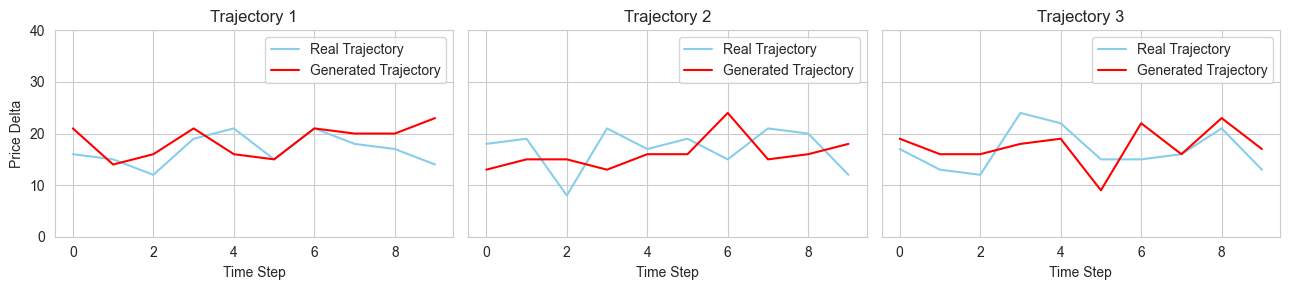

GAIL WITH ENTROPY LOSS


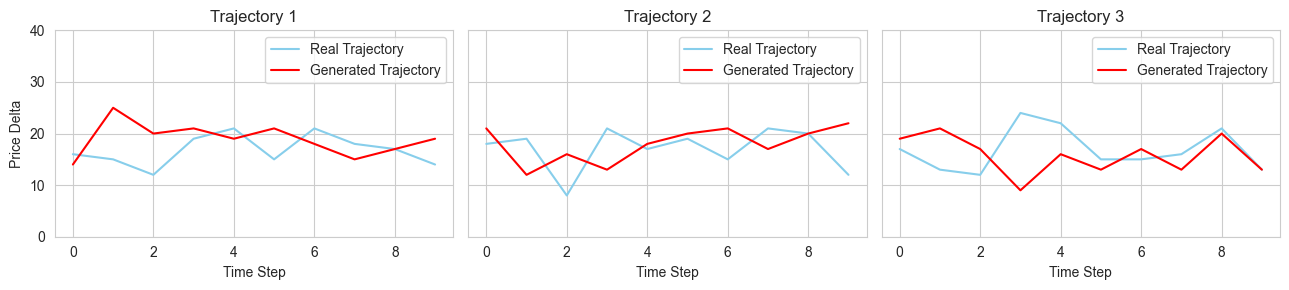

SUPERVISED TRAINING


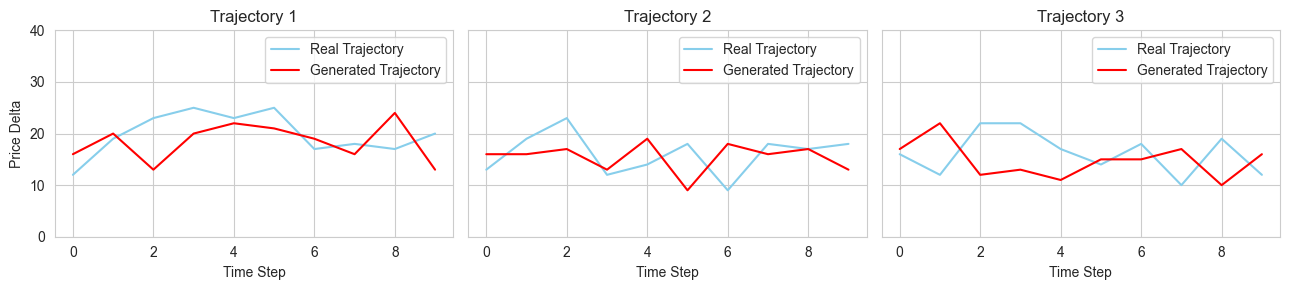

In [120]:
models = [[env_init, model_inint, 'Random Initialization'], [env_1, model_1, 'GAIL WITHOUT ENTROPY LOSS'], [env_2, model_2, 'GAIL WITH ENTROPY LOSS']]

for model in models:
        
    sim_sequences = []

    for sequence in val_data:
        
        _, _ = model[0].reset()
        done = False
        curr_seq_sim  = []

        action = sequence[0]

        while not done:
            action, _ = model[1].predict(action, deterministic=False)
            _, _, done, _, _ = model[0].step(action)
            curr_seq_sim.append(action.item())
        sim_sequences.append(curr_seq_sim)

    real_seq = val_data[:,1:]
    sim_seq = np.array(sim_sequences)

    print(model[2])

    # Set Seaborn style with custom grid transparency
    sns.set_style("whitegrid", rc={"grid.alpha": 0.5})  # Adjust grid transparency to 0.3

    # Create the subplots
    fig, axes = plt.subplots(1, 3, figsize=(13, 3))  # 1 row, 3 columns
    axes = axes.flatten()

    # Plot the real and simulated trajectories
    for i in range(3):
        axes[i].plot(real_seq[i+50], label='Real Trajectory', color='skyblue', linewidth=1.5)
        axes[i].plot(sim_seq[i+50], label='Generated Trajectory', color='red', linewidth=1.5)
        axes[i].legend(loc='best')
        axes[i].set_title(f'Trajectory {i+1}')
        axes[i].set_ylim(0, 40)
        axes[i].set_xlabel('Time Step')
        
        if i == 0:  # Only set y-axis label on the first plot
            axes[i].set_ylabel('Price Delta')
        else:
            axes[i].tick_params(labelleft=False)  # Remove y-axis labels and ticks for the 2nd and 3rd plots

    # Adjust spacing between plots to bring them closer
    plt.subplots_adjust(wspace=0)  # Reduce space between plots
    plt.tight_layout()
    plt.show()

print('SUPERVISED TRAINING')

# Set Seaborn style with custom grid transparency
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})  # Adjust grid transparency to 0.3

# Create the subplots
fig, axes = plt.subplots(1, 3, figsize=(13, 3))  # 1 row, 3 columns
axes = axes.flatten()

# Plot the real and simulated trajectories
for i in range(3):
    axes[i].plot(test_data[i][1:], label='Real Trajectory', color='skyblue', linewidth=1.5)
    axes[i].plot(trajectories[i][1:], label='Generated Trajectory', color='red', linewidth=1.5)
    axes[i].legend(loc='best')
    axes[i].set_title(f'Trajectory {i+1}')
    axes[i].set_ylim(0, 40)
    axes[i].set_xlabel('Time Step')
    
    if i == 0:  # Only set y-axis label on the first plot
        axes[i].set_ylabel('Price Delta')
    else:
        axes[i].tick_params(labelleft=False)  # Remove y-axis labels and ticks for the 2nd and 3rd plots

# Adjust spacing between plots to bring them closer
plt.subplots_adjust(wspace=0)  # Reduce space between plots
plt.tight_layout()
plt.show()

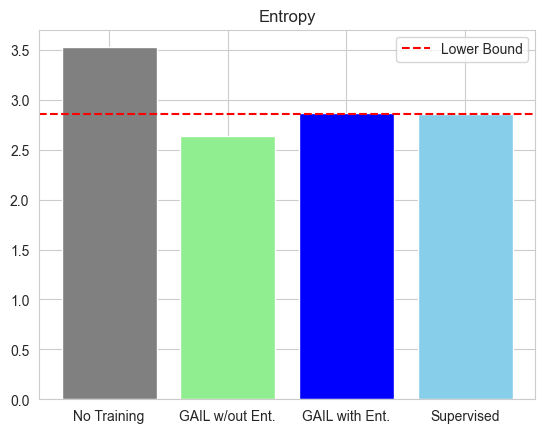

In [131]:
plt.bar(['No Training', 'GAIL w/out Ent.', 'GAIL with Ent.', 'Supervised'], [entropy_init, entropy_model1, entropy_model2, entropy_val], color=('grey','lightgreen', 'blue', 'skyblue'))
plt.axhline(calculate_entropy(np.concatenate(val_data), base='ln'), color='r', linestyle='--', label='Lower Bound')
plt.title('Entropy')
plt.legend()
plt.show()